In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Output layout adjustment

For compact printing: makes output fit the width of the cell.\
Sourced here: https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results

In [ ]:

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# DReaM_corpus

In [ ]:
!wget https://cl.lingfil.uu.se/... # Sorry, but publicly unavailable due to the copyright reasons!!!

In [ ]:
%time

"""Obtain hh.bib file for filtering DReaM corpus data"""

!apt-get install -y wget
url = 'https://drive.google.com/uc?id=1-zNOVHMj6l2cIMZ55a31GQfH2AjWLzad'
output = 'hh.bib'
!wget --no-check-certificate "$url" -O "$output"
output

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 14.8 µs
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1).
^C
--2024-03-31 12:01:41--  https://drive.google.com/uc?id=1-zNOVHMj6l2cIMZ55a31GQfH2AjWLzad
Resolving drive.google.com (drive.google.com)... 142.251.2.139, 142.251.2.138, 142.251.2.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1-zNOVHMj6l2cIMZ55a31GQfH2AjWLzad [following]
--2024-03-31 12:01:41--  https://drive.usercontent.google.com/download?id=1-zNOVHMj6l2cIMZ55a31GQfH2AjWLzad
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, await

'hh.bib'

In [ ]:
!cp "/content/drive/MyDrive/grammars/dreambib.py" .

In [ ]:
import zipfile
import os

"""Download Euroasia folders from DReaM-corpus to '/content'"""

zip_file_path = '/content/besttxtall.zip'
target_folders = ['ptxt2/eurasia']
extraction_directory = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()

    for folder in target_folders:
        folder_path = os.path.join(extraction_directory, folder)
        os.makedirs(folder_path, exist_ok=True)

    for file in file_list:
        for folder in target_folders:
            if file.startswith(folder):
                zip_ref.extract(file, extraction_directory)

In [ ]:
%time
import os
import json
import spacy
from collections import defaultdict
from tqdm import tqdm
from spacy.tokens import Doc
import pandas as pd
import dreambib

"""Creat json dataframe for selected books"""



en_nlp = spacy.load("en_core_web_sm")
en_nlp.max_length = 3000000

def load(fn, encoding = "utf-8"):
    """adopting to the new file storage"""
    if not os.path.exists(fn):
        fn = fn.replace("\\", "/")
        fn_full_path = '/content/' + fn
        fn = fn_full_path
    if os.path.exists(fn):
        with open(fn, 'r', encoding = encoding, errors = "replace") as f:
            utxt = f.read()
        return utxt
    else:
        return None

def process_in_chunks(text, chunk_size):
    start = 0
    processed_docs = []
    while start < len(text):
        end = start + chunk_size
        while end < len(text) and not text[end].isspace():
            end += 1
        processed_docs.append(en_nlp(text[start:end].strip()))
        start = end
    doc = Doc.from_docs(processed_docs)
    return doc

e = dreambib.getu("hh.bib")                                                     # appr. time 2'
print(len(e), "many entries")

"""Iterate through all documents to create a list of grammars
written in ['meta_lang'] if 'besttxt' exists"""

meta_lang = ['rus']   #choices: ['rus']
data = defaultdict(list)
not_existing, books_data = [], []


for (k, (typ, fields)) in tqdm(list(e.items()),desc="Processing documents"):
    if "grammar" in dreambib.hhtype((typ, fields)) and "besttxt" in fields:
        if dreambib.inlg(e[k]) == meta_lang:
            inlg = dreambib.inlg(e[k])
            lg_code = dreambib.lgcode(e[k])
            year = fields['year']
            filename = fields["besttxt"].split('\\')[-1]
            if len(lg_code) < 1:
                print(lg_code)
            else:
                besttxt_content = load(fields["besttxt"])
                if besttxt_content is None:
                    not_existing.append(k)
                else:
                    book_data = {
                    "about": lg_code,
                    "in": inlg[0],
                    "length": len(besttxt_content),
                    "filename": filename,
                    "year": year,
                    "author": k,
                    #"sents_n": [sent.text for sent in doc.sents],
                    #"tokens_n": [token.text for token in doc if any(c.isalpha() for c in token.text)],
                    "content": besttxt_content
                    }

                    data[lg_code[0]].append(besttxt_content)
                    books_data.append(book_data)
print(f'{meta_lang} books are about {len(data)} languages, these files do not exist: {not_existing}')
print(f'In total we have {len(books_data)} books in {meta_lang}')
print(f'The languages described are: {", ".join(data.keys())}')

# Write the data to a JSON file
output_file_path = '/content/drive/MyDrive/grammars/rus_books_data.json'
with open(output_file_path, 'w', encoding='utf-8') as output_file:
    json.dump(books_data, output_file, indent=2)

print(f'Data has been written to {output_file_path}')

In [ ]:
import json
import pandas as pd


eng = "/content/drive/MyDrive/grammars/eng_books_data.json"
rus = "/content/drive/MyDrive/grammars/rus_books_data.json"
with open(rus, 'r', encoding="utf-8") as jf:
    data = json.load(jf)

In [ ]:
"""Creating language maps: a dictionary of a book name: lang_code"""

b_folder = '/content/drive/MyDrive/grammars/ws_removed_gr'
save_to = "/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map"

lang = {}
for file in os.listdir(b_folder):
    lang[file] = bdf.loc[bdf['filename'] == file, 'about'].values[0][0]

save_file = os.path.join(save_to, 'langs.json')
with open (save_file, 'w') as l:
     json.dump(lang, l)

In [ ]:
"""Checking statistics for the Thesis"""

# max_length = bdf[bdf['year'] > '1990']['length'].max()
# min_length = bdf[bdf['year'] > '1990']['length'].min()
# aver_length = bdf[bdf['year'] > '1990']['length'].median()
# total_length = bdf[bdf['year'] > '1990']['length'].sum()

# max_length_row = bdf.loc[bdf[bdf['year'] > '1990']['length'].idxmax()]
# file_name_for_max_length = max_length_row['filename']

# min_length_row = bdf.loc[bdf[bdf['year'] > '1990']['length'].idxmin()]
# file_name_for_min_length = min_length_row['filename']

aver_length_row = bdf.loc[bdf['length'].idxmean()]
file_name_for_max_length = aver_length_row['filename']

print(f"File Name for Max Length: {file_name_for_max_length}")
print(f"File Name for Min Length: {file_name_for_min_length}")
#print(f"File Name for Aver Length: {file_name_for_aver_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")
print(f"Average Length: {aver_length}")
print(f"Total Length: {total_length}")

File Name for Max Length: huddleston-pullum_english2002_o.txt
File Name for Min Length: kansakaretal_baram2011_o.txt
Max Length: 5681975
Min Length: 82973
Average Length: 631706.8485829959
Total Length: 510720791


# Preliminary preprocessing:


## What is the normal ratio for white space in a text?

According to article of
 Martens, S & Mooij, Joris & Hill, N. & Farquhar, J. & Schölkopf, Bernhard. (2010). A Graphical Model Framework for Decoding in the Visual ERP-Based BCI Speller. Neural computation. 23. 160-82. 10.1162/NECO_a_00066.
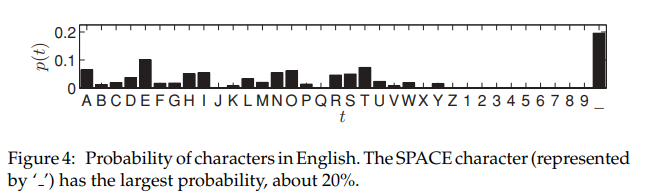

In [ ]:
from collections import Counter

def open_file(file):
    with open(file, 'r', encoding = 'utf-8') as f:
        file = f.read()
    return list(file)

#book = "/content/drive/MyDrive/grammars/original_gr/andrews_russian2004v2_o.txt"  # good OCR
book = "/content/drive/MyDrive/grammars/original_gr/poppe_bashkir1964_o.txt"   # doubtful OCR
char_stat = Counter(open_file(book))
book_size = len(open_file(book))
assert sum(char_stat.values()) == book_size


print("Number of unique character:", len(char_stat))
print("White space ratio:", char_stat[' ']/book_size)
print("'e'ratio:", char_stat['e']/book_size)
print("Proportion of 'e' and ' '(norm ~ 0.5 and >):",(char_stat['e']/book_size)/(char_stat[' ']/book_size))

Number of unique character: 198
White space ratio: 0.2769579304061066
'e'ratio: 0.03963069706754313
Proportion of 'e' and ' '(norm ~ 0.5 and >): 0.14309284088537266


## Clean up text with whitespace remover

Hannah Bast, Matthias Hertel, and Sebastian Walter. 2023. Fast Whitespace Correction with Encoder-Only Transformers. In Proceedings of the 61st Annual Meeting of the Association for Computational Linguistics (Volume 3: System Demonstrations), pages 389–399, Toronto, Canada. Association for Computational Linguistics.

In [ ]:
!git clone https://github.com/ad-freiburg/whitespace-correction.git


Cloning into 'whitespace-correction'...
remote: Enumerating objects: 2449, done.
remote: Counting objects: 100% (759/759), done.
remote: Compressing objects: 100% (267/267), done.
remote: Total 2449 (delta 433), reused 745 (delta 421), pack-reused 1690
Receiving objects: 100% (2449/2449), 25.41 MiB | 23.36 MiB/s, done.
Resolving deltas: 100% (1357/1357), done.


In [ ]:
%time
!cd whitespace-correction
!pip install whitespace-correction

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from typing_extensions import ContextManager
%time
import json
import os
from collections import Counter


fine_without_remove = "/content/drive/MyDrive/grammars/ws_removed_gr/"
needs_ws_remove = "/content/drive/MyDrive/grammars/original_gr/"

lang_1, lang_2 = {}, {}
for index, row in bdf.iterrows():
    if row['year'] > str(1990):
        filename = row['filename']
        content = row['content']
        char_stat = Counter(list(content))
        book_size = row['length']
        assert sum(char_stat.values()) == book_size
        #print(type(content))
        if (char_stat['e']/book_size)/(char_stat[' ']/book_size) < 0.5:
            output_file = os.path.join(needs_ws_remove, filename)
            lang_1[filename] = (row['about'][0])
            with open(output_file, 'w', encoding='utf-8') as orig_f:
                orig_f.write(content)
        else:
            lang_2[filename]=(row['about'][0])
            out_file = os.path.join(fine_without_remove, filename)
            with open(out_file, 'w', encoding='utf-8') as file:
                file.write(content)

lang_file = "langs.json"
for lang, path in zip([lang_1, lang_2], [needs_ws_remove, fine_without_remove]):
    lang_path = os.path.join(path, lang_file)
    with open(lang_path, 'w') as l_file:
        json.dump(lang, l_file, indent=2)

print("Distributing completed.")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs
Distributing completed.


In [ ]:
import json

path_or = "/content/drive/MyDrive/grammars/original_gr/book_language_map/langs.json"
path_ws = "/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs.json"

obj_langs = set()
for path in [path_or, path_ws]:
    with open(path, 'r', encoding='utf-8') as langs:
        data=json.load(langs)
        obj_langs.update(data.values())
print(len(obj_langs))
print(214+497)

427
711


In [ ]:
%time
from whitespace_correction import WhitespaceCorrector                           # 1h 18 min inprocessed
import os

input_path = "/content/drive/MyDrive/grammars/unprocessed/"
output_path = "/content/drive/MyDrive/grammars/ws3_removed_gr/"


def ws_remove(input_file, output_file):
    cor = WhitespaceCorrector.from_pretrained()
    cor.to("cuda")
    cor.set_precision("fp32")
    #cor.set_precision("fp16")

    cor.correct_file(input_file, output_file=output_file)


# Iterate through files in original_gr
for filename in os.listdir(input_path):
    full_path = os.path.join(input_path, filename)
    if os.path.isdir(full_path):
        continue
    input_file = os.path.join(input_path, filename)
    output_file = os.path.join(output_path, filename)
    #print(input_file, output_file)
    ws_remove(input_file, output_file)


print("Preprocessing completed.")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


2024-03-02 17:34:42,236 [WHITESPACE CORRECTION DOWNLOAD] [INFO] downloading eo_large_byte from https://ad-publications.informatik.uni-freiburg.de/ACL_whitespace_correction_transformer_BHW_2023.materials/eo_large_byte_v2.zip to download directory /usr/local/lib/python3.10/dist-packages/text_utils/api/.download/WHITESPACE_CORRECTION
2024-03-02 17:54:55,802 [WHITESPACE CORRECTION] [INFO] running eo_large_byte whitespace corrector on device Tesla T4 (15,102MiB memory, 7.5 compute capability, 40 multiprocessors)
2024-03-02 17:56:02,442 [WHITESPACE CORRECTION DOWNLOAD] [INFO] eo_large_byte is already downloaded to download directory /usr/local/lib/python3.10/dist-packages/text_utils/api/.download/WHITESPACE_CORRECTION
2024-03-02 17:56:03,000 [WHITESPACE CORRECTION] [INFO] running eo_large_byte whitespace corrector on device Tesla T4 (15,102MiB memory, 7.5 compute capability, 40 multiprocessors)
2024-03-02 17:56:47,051 [WHITESPACE CORRECTION DOWNLOAD] [INFO] eo_large_byte is already downloade

Preprocessing completed.


## Additional cleaning (wasn't used for main dataset)





While analyzing data before extracting embeddings with SBERT, which has a constraint of a maximum sentence length of 128 words, we discovered that some books have sentences with up to 553 tokens. Typically, these entities include indexes, similar sections containing reference numbers, and enumerations of various items. Additionally, there are numerous unreadable foreign words recognized by OCR as Latin characters, and the '\xad' character is present. All of these elements contribute unnecessary noise and may adversely affect the quality of embeddings. Therefore, we are making an effort to clean the texts by:

1.   '\xad' removal
2.   Non-English words
3.   Numbers

In [ ]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 13.7 MB/s eta 0:00:00


In [ ]:
%%time
from concurrent.futures import ProcessPoolExecutor
from spellchecker import SpellChecker
from functools import lru_cache, partial

"""Class SpellCorrector has a .clean() method, that
checks spelling, removes non-english words in Latin alphabet and
diacards '\xad' token."""

class SpellCorrector:
    def __init__(self, chunk_size):
        self.spell = SpellChecker()
        self.chunk_size = chunk_size

    @lru_cache(maxsize=None)
    def cached_correction(self, word):
        return self.spell.correction(word)

    def correction_helper(self, word):
        if word.istitle() or word.isupper():
            return word
        corrected_word = self.cached_correction(word)
        if corrected_word is None:
            return ''
        else:
            return ''.join(w for w in corrected_word
                          if not any(char.isdigit() or
                                      char in ['.',','] for char in w))

    def correct_sentence(self, sentence):
        return ' '.join(self.correction_helper(word) for word in sentence.split()) + '.'

    def clean_batch(self, batch):
        with ProcessPoolExecutor() as executor:
            correction_partial = partial(self.correct_sentence)
            corrected_texts = list(executor.map(correction_partial, batch))
        return corrected_texts

    def clean(self, texts):
        corrected_texts = []
        batch_size =100
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            corrected_texts.extend(self.clean_batch(batch))
        return corrected_texts

if __name__ == "__main__":
    texts_to_correct = ["This is an nglish\xad 1.2 slmple cepgqe.",
                        " Pronunciations variants of CSR in Moscow and St. Petersburg.",
                        "Inc. Townsend, C.E. and L.A. Janda. 1996. Common and Comparative Slavic Phonology."]   # Replace with a list of texts

    t_cl = SpellCorrector(chunk_size=8)
    cleaned_texts = t_cl.clean(texts_to_correct)

    print(len(cleaned_texts), cleaned_texts)
    for original, corrected in zip(texts_to_correct, cleaned_texts):
        print(f"Original text: {original}")
        print(f"Corrected text: {corrected}")
        print("\n")

3 ['This is an english  simple .', 'Pronunciations variants of CSR in Moscow and St. Petersburg..', 'Inc. Townsend, C.E. and L.A. Janda.  Common and Comparative Slavic Phonology..']
Original text: This is an nglish­ 1.2 slmple cepgqe.
Corrected text: This is an english  simple .


Original text:  Pronunciations variants of CSR in Moscow and St. Petersburg.
Corrected text: Pronunciations variants of CSR in Moscow and St. Petersburg..


Original text: Inc. Townsend, C.E. and L.A. Janda. 1996. Common and Comparative Slavic Phonology.
Corrected text: Inc. Townsend, C.E. and L.A. Janda.  Common and Comparative Slavic Phonology..


CPU times: user 298 ms, sys: 101 ms, total: 399 ms
Wall time: 1.35 s


In [ ]:
%%time
import re
import os
import spacy
from tqdm import tqdm

"""class Cleaner cleans up the text by utilyzing SpellCorrector
Cleaner has 2 methods:
.iterater() takes a path as an argument and iterates through files in a folder
and calls .add_cleaning_() method
.add_cleaing_() a hepler function that takes input file and output file as arguments
 opens the input file cleans up the text and write down into a new txt file.
 In case of very long sequences the sentence is devided into shorter ones by chunk_size value"""

class Cleaner:
    def __init__(self, chunk_size=128):
        self.nlp = spacy.load("en_core_web_sm")
        self.chunk_size = chunk_size
        self.spell_corrector = SpellCorrector(self.chunk_size)


    def add_cleaning_(self, input_file, output_file):
            try:
                with open (output_file, 'w', encoding='utf-8') as out_f:
                    with open(input_file, 'r', encoding= 'utf-8') as in_f:
                        book_text = in_f.read()
                        book_sentences = [sent.text for sent in self.nlp(book_text).sents]
                        print(len(book_sentences))

                        # Chunking book_sentences
                        chunked_book_sentences = [book_sentences[i:i + self.chunk_size] for i in range(0, len(book_sentences), self.chunk_size)]
                        del book_text
                        del book_sentences
                        cleaned_chunks = []
                        for chunk in tqdm(chunked_book_sentences, desc = "Processing chunks"):
                            cleaned_chunk = self.spell_corrector.clean(chunk)
                            cleaned_chunk = ' '.join(w for w in cleaned_chunk if w is not None)
                            cleaned_chunks.append(cleaned_chunk)

                        cleaned_book = ' '.join(cleaned_chunks)
                        out_f.write(cleaned_book)
                        del cleaned_chunk
            except Exception as e:
                print(f"An error occurred while processing {input_file}: {str(e)}")

    def iterater(self, input_path):
      output_path =  os.path.join('/'.join(input_path.split('/')[:-2]), "add_cleaned_gr")
      os.makedirs(output_path, exist_ok=True)
      for filename in os.listdir(input_path):
          input_file = os.path.join(input_path, filename)
          if not os.path.isdir(input_file):
              output_file = os.path.join(output_path, filename)
              # print('in', input_file, 'out', output_file)
              self.add_cleaning_(input_file, output_file)


if __name__=="__main__":
    ws_cleaned_books = "/content/drive/MyDrive/grammars/ws_removed_gr/"
    clean_books = Cleaner()
    #clean_books.iterater(ws_cleaned_books)
    clean_books.add_cleaning_("/content/drive/MyDrive/grammars/ws_removed_gr/borras-christian_russian1959v2_o.txt",
                             "/content/drive/MyDrive/grammars/add_cleaned_gr/borras-christian_russian1959v2_o.txt")
    print("Preprocessing completed.")

In [ ]:
import spacy
from spacy.tokens import Doc
from collections import Counter

"""The cells is checking the results of text cleaning."""

en_nlp = spacy.load("en_core_web_sm")
input_file = "/content/drive/MyDrive/grammars/ws_removed_gr/andrews_russian2004v2_o.txt"
output_file = "/content/drive/MyDrive/grammars/add_cleaned_gr/andrews_russian2004v2_o (1).txt"
def open_file(file):
    with open(file, 'r', encoding = 'utf-8') as f:
        file = f.read()
    return file

in_b = len(open_file(input_file))
out_b = len(open_file(output_file))

print("Before:", in_b)
print("After:", out_b)
print("Difference:", in_b - out_b)

def stat(book):
    nlp_book= en_nlp(book)
    tokens = [token.text for token in nlp_book if any(c.isalpha() for c in token.text)]
    stat = Counter(tokens)
    return stat



stat_before = stat(open_file(input_file))
stat_after = stat(open_file(output_file))
print("# before:", stat_before['adverb'])
print("# after:", stat_after['adverb'])

Before: 214342
After: 166214
Difference: 48128
# before: 7
# after: 7


# Baseline: BoW with full raw text

Minimal dimentionality for the best result is 8000.

The strongest signal have grammatically unrelated terms:

*   either shortening/abbreviations
*   samples from national languages
*   names of the languages!!!


In [ ]:
%%time
import json
import os
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import vstack
import time
import numpy as np
import pandas as pd

"""Class to obtain Bow vectors of books"""


class Doc2BoW:
    def __init__(self, path, max_features = 30000, min_df = 5, max_df = 0.85, ngram_range = (1,1)):
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.path = path
        self.max_features = max_features
        self.preprocess = self.path.split('/')[-1]
        self.vectorizer = CountVectorizer(input='filename', stop_words="english",
                                          min_df=self.min_df, max_df=self.max_df,
                                          ngram_range=self.ngram_range,
                                          max_features = self.max_features)


    def vectorize(self, save_path):
        file_paths = [os.path.join(self.path, file) \
                      for file in os.listdir(self.path) \
                       if not os.path.isdir(os.path.join(self.path, file))]
        file_names = [file for file in os.listdir(self.path)\
                       if not os.path.isdir(os.path.join(self.path, file))]

        bow_matrix = self.vectorizer.fit_transform(file_paths)
        feature_names = self.vectorizer.get_feature_names_out()


        mmapped_file = np.memmap('dense_bow_matrix.dat', dtype='float32', mode='w+',
                        shape=(len(file_names), len(self.vectorizer.vocabulary_)))

        dense_bow_matrix = bow_matrix.toarray()
        del bow_matrix

        result_dict = {}
        for i, file_name in enumerate(file_names):
            mmapped_file[i] = dense_bow_matrix[i]
            result_dict[file_name] = mmapped_file[i].tolist()

        file = os.path.join(save_path, "BoW", self.preprocess, str(self.max_features)+'_'
                            +str(self.min_df)+"_" + str(self.max_df) + "_" + str(self.ngram_range) + "3.json")
        os.makedirs(os.path.dirname(file), exist_ok=True)
        with open(file, 'w') as json_file:
            json.dump(result_dict, json_file)                                   # len(result_dict) = 502

        # feature_file = os.path.join("/content/drive/MyDrive/grammars/Features_/",
        #                             "BoW_"+ str(self.max_features) + ".txt")
        # os.makedirs(os.path.dirname(file), exist_ok=True)
        # with open(feature_file, 'w') as f_file:
        #     for feature_name in feature_names:
        #         f_file.write(feature_name + '\n')

if __name__=="__main__":
    path = "/content/drive/MyDrive/grammars/ws3_removed_gr"
    save_path = "/content/drive/MyDrive/grammars/embeddings"
    model = Doc2BoW(path, max_features= 8000)
    model.vectorize(save_path)

CPU times: user 12 s, sys: 205 ms, total: 12.2 s
Wall time: 31 s


In [ ]:
import numpy as np

# the file path where feature names are saved
k7_path = "/content/drive/MyDrive/grammars/Features_/BoW_7000.txt" #not enough
k8_path = "/content/drive/MyDrive/grammars/Features_/BoW_8000.txt"

f_l = []
for file_path in [k7_path, k8_path]:
    with open(file_path, 'r') as file:
        f_l.append(np.array([line.strip() for line in file]))

overlapping_values = np.intersect1d(f_l[0], f_l[1])

# values unique to each array
unique_values_k7 = np.setdiff1d(f_l[0], f_l[1])
unique_values_k8 = np.setdiff1d(f_l[1], f_l[0])

print(f'overlapping_values: {overlapping_values}')
print(f'unique for better BoW_8k: {unique_values_k8}')

overlapping_values: ['00' '000' '001' ... 'ﬁrst' 'ﬁsh' 'ﬁve']
unique for better BoW_8k: ['10a' '11a' '13a' '1930' '1934' '1937' '1939' '1949' '1950' '1951' '1952'
 '2001a' '21a' '2du' '3pp' '3ps' '3sf' '3sposs' '546' '547' '548' '549'
 '550' '552' '556' '562' '564' '565' '568' '569' '572' '573' '574' '575'
 '576' '577' '578' '579' '580' '581' '582' '584' '586' '588' '589' '592'
 '595' '599' '5c' '601' '602' '606' '610' '611' '612' '613' '615' '616'
 '617' '618' '619' '639' '640' '646' '647' '657' '7b' '8b' '900' 'aat'
 'abandon' 'abi' 'abo' 'abundant' 'acceptability' 'accomplishment'
 'accord' 'ach' 'acknowledgements' 'actors' 'acute' 'adaptation' 'addit'
 'adequate' 'adjoined' 'adu' 'advise' 'aforementioned' 'afterthought'
 'agriculture' 'ais' 'ake' 'akin' 'ako' 'alan' 'algo' 'allen' 'alternant'
 'alveo' 'aman' 'amma' 'analyzing' 'anaphorically' 'angl' 'animates'
 'ankara' 'answering' 'ante' 'anthropological' 'anthropology' 'api'
 'apico' 'appo' 'approaching' 'approximation' 'aquí' 'a

prefix: 0.0


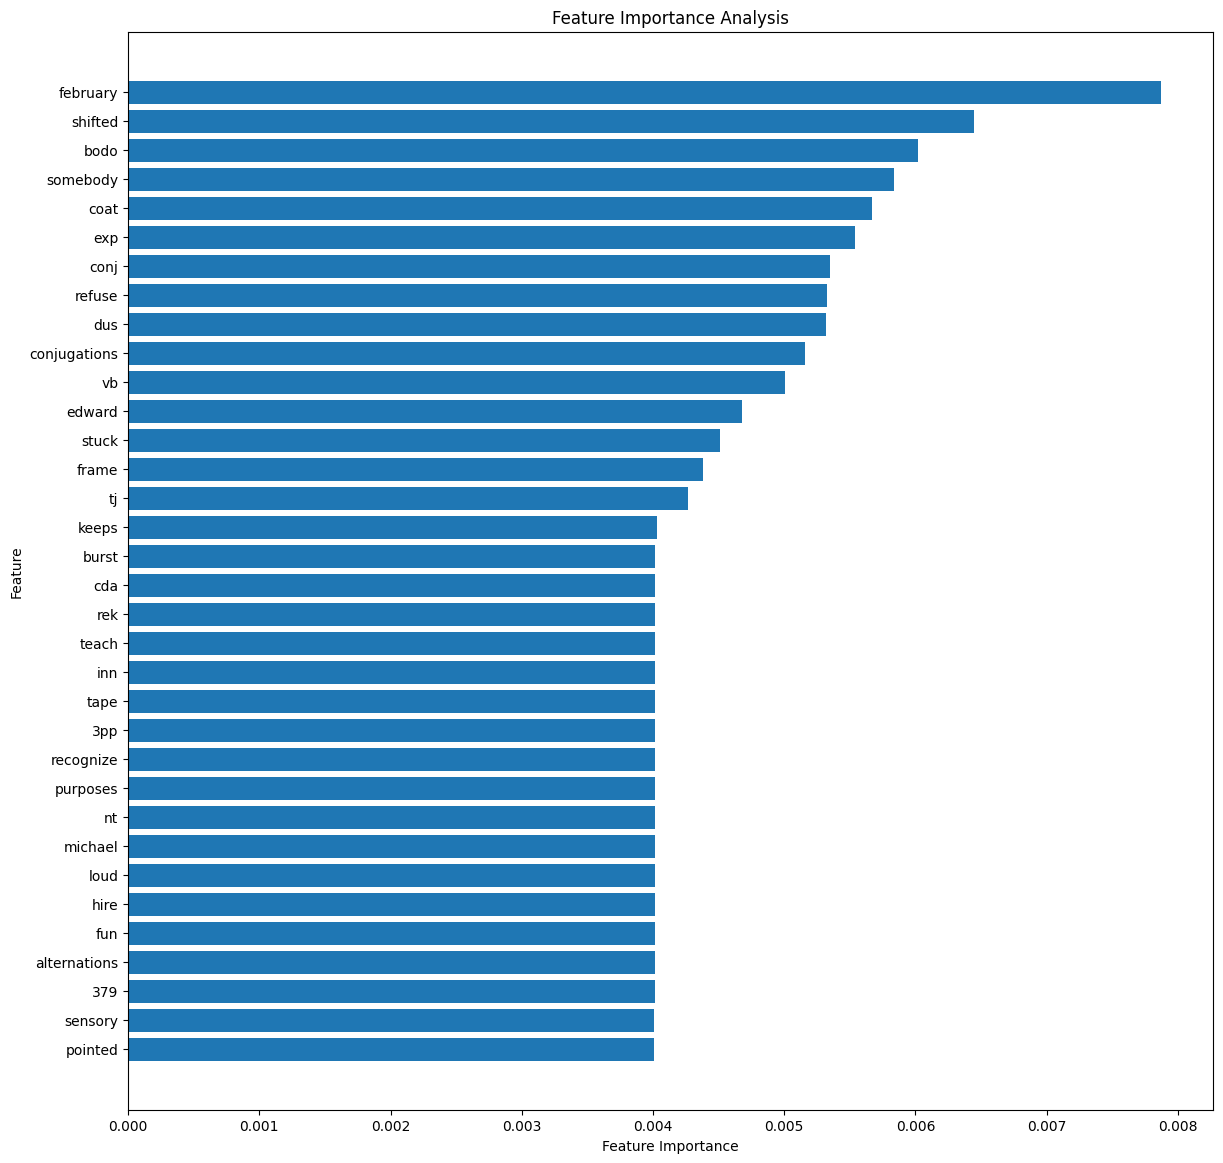

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import json

best_model = "/content/drive/MyDrive/grammars/embeddings/BoW/ws_removed_gr/8k_5_0.85_(1, 1).json"
with open(best_model, 'r') as file:
    b_vectors = json.load(file)

book_vectors = dict(sorted(b_vectors.items()))
X = np.array(list(book_vectors.values()))

with open("/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs.json", "r") as l:
    langs = json.load(l)

languages = dict(sorted(langs.items()))
for b, b1 in zip(list(languages.keys()), list(book_vectors.keys())):
    if b != b1:
        print(b, b1)

if 'turnbull_nepali1992[1923].txt' not in languages:
    languages['turnbull_nepali1992[1923].txt'] = 'npi'
    with open("/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs.json", "w") as l:
        json.dump(languages, l)

class_names = np.array(list(langs.values()))

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(class_names)
clf = DecisionTreeClassifier()
clf.fit(X, y)
feature_importances = clf.feature_importances_

ftr_path = "/content/drive/MyDrive/grammars/Features_/BoW_8000.txt"
with open(ftr_path, 'r') as frt:
    feature_names = [line.strip() for line in frt]

f_n, f_i = [], []
fni = {}

for feature, importance in zip(feature_names, feature_importances):
    if feature in ["suffix", "prefix"]:
        print(f"{feature}: {importance}")
    if importance > 0.004:
        #print(f"{feature}: {importance}")
        fni[feature] = importance
        f_n.append(feature)
        f_i.append(importance)
s_fni = dict(sorted(fni.items(), key=lambda item: item[1]))

# Plot feature importances
fig, ax = plt.subplots(figsize=(14, 14))
plt.barh(list(s_fni.keys()), list(s_fni.values()))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Analysis')
plt.show()


[0. 2. 0. ... 0. 0. 0.] 187


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


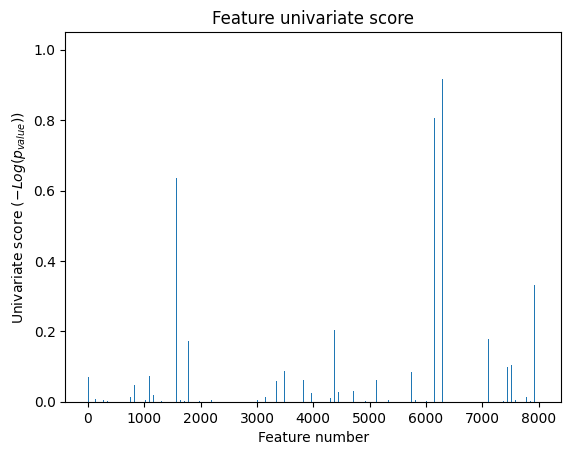

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

print(X[0], y[0])


# Apply VarianceThreshold to remove features with zero variance
selector_variance = VarianceThreshold()
X_filtered = selector_variance.fit_transform(X)

# Apply SelectKBest after removing features with zero variance
selector_kbest = SelectKBest(f_classif, k=1000)
selector_kbest.fit(X_filtered, y)

# Avoid division by zero
selector_pvalues = selector_kbest.pvalues_
selector_pvalues[selector_pvalues == 0] = np.finfo(float).eps

scores = -np.log10(selector_pvalues)
scores /= scores.max()


X_indices = np.arange(X.shape[-1])

plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()



In [ ]:
most_important = {}
for i, score in zip(X_indices, scores):
    if score > 0.15:
        most_important[feature_names[i]] = score

sorted_most_improtant = dict(sorted(most_important.items(), key=lambda item: item[1], reverse=True))
for k, v in sorted_most_improtant.items():
    print(f"{k} : {v}")


appo : 1.0
txt : 0.9835222728681035
nǝ : 0.9785687003118685
snr : 0.970708297390658
zep : 0.9696260402154258
gju : 0.9655682831661009
dukpa : 0.9483516731192455
csl : 0.9450120355537165
chakma : 0.9412446262669216
འག : 0.9262369123937694
på : 0.9239047744933868
བཅ : 0.9225475419841841
korbong : 0.9222058151487045
liangmai : 0.9220824880561338
rø : 0.9173301439942779
wera : 0.9108414944846689
lezgian : 0.8913037395433446
pts : 0.8911719189872925
eskimo : 0.889647971741652
nre : 0.8893268766721852
pashai : 0.882992594471157
denjongke : 0.8817882229483137
brazilian : 0.8743199885204145
rua : 0.8538326937398075
ppr : 0.8443925946868621
3o : 0.8439690229921551
iň : 0.8409904861855898
yz : 0.8390590203662306
བར : 0.8239697398845442
alexander : 0.8154317851035546
ma31 : 0.8093737523078234
reproduction : 0.8071029826470633
ངས : 0.7917375561606577
əl : 0.7898281597951843
jill : 0.7857874084618035
iyya : 0.7790170783059439
པའ : 0.7766426829764903
བས : 0.775772581523068
mǝ : 0.761724158745983
adn

# Baseline: Bow with Language Vocabulary

1) Getting glottolog for forming the language vocabulary

In [ ]:
!pip install pyglottolog

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.9 MB/s e

In [ ]:
!git clone https://github.com/glottolog/glottolog.git

Cloning into 'glottolog'...
remote: Enumerating objects: 906563, done.
remote: Counting objects: 100% (115049/115049), done.
remote: Compressing objects: 100% (56631/56631), done.
remote: Total 906563 (delta 36523), reused 106470 (delta 36003), pack-reused 791514
Receiving objects: 100% (906563/906563), 1.07 GiB | 15.75 MiB/s, done.
Resolving deltas: 100% (329701/329701), done.
Updating files: 100% (27062/27062), done.


In [ ]:
from pyglottolog import Glottolog


glottolog_repo_dir = "/content/glottolog"
glottolog = Glottolog(repos=glottolog_repo_dir)

languages = glottolog.languoids()
language_names = {language.id: language.name.lower() for language in languages}

unique_lang = list(set(language_names.values()))
print("Total number of language names extracted from Glottilog is", len(unique_lang))

26878


In [ ]:
assert 'georgian' in unique_lang
assert 'turkmen' in unique_lang

In [ ]:
%%time
import json
import os
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import vstack
import time
import numpy as np
import pandas as pd

"""Class to obtain BoW vectors of books"""


class Doc2BoW:
    def __init__(self, path, vocabulary, min_df = 1, max_df = 1.0, ngram_range = (1,1)):
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.path = path
        self.vocabulary = vocabulary
        self.preprocess = self.path.split('/')[-1]
        self.vectorizer = CountVectorizer(input='filename', stop_words="english",
                                          min_df=self.min_df, max_df=self.max_df,
                                          ngram_range=self.ngram_range,
                                          vocabulary=self.vocabulary,
                                          max_features = 30000)


    def vectorize(self, save_path):
        file_paths = [os.path.join(self.path, file) \
                      for file in os.listdir(self.path) \
                      if not os.path.isdir(os.path.join(self.path, file))] #or '.ipynb_checkpoints' not in file]
        print(len(file_paths))
        file_names = [file for file in os.listdir(self.path)\
                      if not os.path.isdir(os.path.join(self.path, file))] # or '.ipynb_checkpoints' not in file]
        print(len(file_names))

        #assert len(file_paths) == 711
        assert len(file_names) == len(file_paths)

        bow_matrix = self.vectorizer.fit_transform(file_paths)
        #feature_names = self.vectorizer.get_feature_names_out()

        mmapped_file = np.memmap('dense_bow_matrix.dat', dtype='float32', mode='w+',
                        shape=(len(file_names), len(self.vectorizer.vocabulary_)))

        dense_bow_matrix = bow_matrix.toarray()
        del bow_matrix

        result_dict = {}
        for i, file_name in enumerate(file_names):
            mmapped_file[i] = dense_bow_matrix[i]
            result_dict[file_name] = mmapped_file[i].tolist()


        file = os.path.join(save_path, "BoW_LV", self.preprocess,
                            str(self.min_df)+"_" + str(self.max_df) + "_" + str(self.ngram_range) + ".json")
        os.makedirs(os.path.dirname(file), exist_ok=True)
        with open(file, 'w') as json_file:
            json.dump(result_dict, json_file)

if __name__=="__main__":
    path = "/content/drive/MyDrive/grammars/ws_removed_gr"
    save_path = "/content/drive/MyDrive/grammars/embeddings"
    model = Doc2BoW(path, unique_lang)
    model.vectorize(save_path)

# Baseline: TFIDF

In [ ]:
%%time
import json
import os
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack
import time
import numpy as np
import pandas as pd

"""Class to obtain Bow vectors of books"""


class Doc2tfidf:
    def __init__(self, path, max_features = 30000, min_df = 5, max_df = 0.5, ngram_range = (1,1)):
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.path = path
        self.max_features = max_features
        self.preprocess = self.path.split('/')[-1]
        self.vectorizer = TfidfVectorizer(input='filename', stop_words="english",
                                          min_df=self.min_df, max_df=self.max_df,
                                          ngram_range=self.ngram_range,
                                          max_features = self.max_features)


    def vectorize(self, save_path):
        file_paths = [os.path.join(self.path, file) \
                      for file in os.listdir(self.path) \
                       if not os.path.isdir(os.path.join(self.path, file))]
        file_names = [file for file in os.listdir(self.path)\
                       if not os.path.isdir(os.path.join(self.path, file))]

        bow_matrix = self.vectorizer.fit_transform(file_paths)
        feature_names = self.vectorizer.get_feature_names_out()

        mmapped_file = np.memmap('dense_bow_matrix.dat', dtype='float32', mode='w+',
                        shape=(len(file_names), len(self.vectorizer.vocabulary_)))

        dense_bow_matrix = bow_matrix.toarray()
        del bow_matrix

        result_dict = {}
        for i, file_name in enumerate(file_names):
            mmapped_file[i] = dense_bow_matrix[i]
            result_dict[file_name] = mmapped_file[i].tolist()

        file = os.path.join(save_path, "TF_IDF", self.preprocess, str(self.max_features).strip('000') + "k_" +
                            str(self.min_df)+"_" + str(self.max_df) + "_" +
                            str(self.ngram_range) + str(len(result_dict))+"".json")
        os.makedirs(os.path.dirname(file), exist_ok=True)
        with open(file, 'w') as json_file:
            json.dump(result_dict, json_file)

        # feature_file = os.path.join("/content/drive/MyDrive/grammars/Features_", "TFIDF" +
        #                             str(self.max_features) + ".txt")
        # os.makedirs(os.path.dirname(feature_file), exist_ok=True)
        # with open(feature_file, 'w') as f_file:
        #     for feature_name in feature_names:
        #         f_file.write(feature_name + '\n')

if __name__=="__main__":
    path = "/content/drive/MyDrive/grammars/ws_removed_gr"
    save_path = "/content/drive/MyDrive/grammars/embeddings"
    model = Doc2tfidf(path, max_features=8000)
    model.vectorize(save_path)

CPU times: user 2min 4s, sys: 3.21 s, total: 2min 8s
Wall time: 2min 41s


# Baseline: doc2vec with chunked text:

## Obtaining book - sentences data from book_facets data

In [ ]:
%%time
import json
import pandas as pd


path = "/content/drive/MyDrive/grammars/wsr711_sf_books.json"
with open(path, 'r', encoding='utf-8') as jf:
    facets =  json.load(jf)


book_data = {}
for book, facets in facets.items():
    all_sentences = []
    for facet, f_sentences in facets.items():
        all_sentences.extend(f_sentences)
        book_sentences_set = list(set(all_sentences))
    book_data[book] = book_sentences_set
    del book_sentences_set

output_file = "/content/drive/MyDrive/grammars/wsr711_s_books.json"
with open(output_file, 'w', encoding="utf-8") as file:
    json.dump(book_data, file)

CPU times: user 16.7 s, sys: 8.03 s, total: 24.8 s
Wall time: 41.9 s


## Extracting D2V embeddings as average of all sentences embeddings in the book

In [ ]:
%%time
import time                                                                     # Wall time: 57.9 s for 502 books
import os
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import json
import numpy as np


class Doc2vec:
    def __init__(self, dimention=100, window=5, min_count=1, workers=4, epochs=20):
        self.dimention = dimention
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs
        self.model = Doc2Vec(vector_size=self.dimention, window=self.window,
                             min_count=self.min_count, workers=self.workers,
                             epochs=self.epochs)

    def train(self, book_sents, save_path="/content/drive/MyDrive/grammars",
              save = True):
        tagged_data = []
        for book, sents in book_sents.items():
            tag = f'{book}'
            tagged_data.append(TaggedDocument(words=sents,
                                                tags=[tag]))

        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count,
                         epochs=self.model.epochs)
        if save:
            self.model.save(save_path)

    def vectorize(self, book_sents,
                  save_path = "/content/drive/MyDrive/grammars/embeddings",
                  book_set = "ws_removed_gr"):
        average_book_embeddings = {}
        for book in book_sents:
            book_tags = [f'{book}' for sent in book_sents[book]]
            sent_embeddings = [self.model.dv[tag] for tag in book_tags]
            a_book_embedding = sum(sent_embeddings) / len(sent_embeddings)
            average_book_embeddings[book] = a_book_embedding.tolist()


        file = os.path.join(save_path, "sents_doc2vec_model", book_set,
                        f"averaged_{self.dimention}_{self.window}_{self.min_count}711.json")
        os.makedirs(os.path.dirname(file), exist_ok=True)
        #print(file)
        with open(file, 'w') as json_file:
            json.dump(average_book_embeddings, json_file)

if __name__ == "__main__":
    D2V = Doc2vec(dimention=1600, window=5, min_count=50, workers=4, epochs=20) # <--- BEST PARAMETERS from probing
    data_file = "/content/drive/MyDrive/grammars/wsr711_s_books.json"
    with open(data_file, 'r', encoding="utf-8") as file:
        sents = json.load(file)
    D2V.train(sents, save = False)
    D2V.vectorize(sents, book_set = "ws_removed_gr")

CPU times: user 51.4 s, sys: 1.93 s, total: 53.3 s
Wall time: 53.5 s
Compiler : 129 ms


# Baseline: sBERT with full raw text

In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
%%time
from sentence_transformers import SentenceTransformer
import json
import os
import warnings
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from collections import defaultdict


max_seq_length=512
def check_max_local_length(max_seq_length, texts):
    max_local_length = np.max([len(t.split()) for t in texts])
    if max_local_length > max_seq_length:
        warnings.simplefilter("always", DeprecationWarning)
        warnings.warn(
            f"the longest document in your collection has {max_local_length} words, the model instead "
            f"truncates to {max_seq_length} tokens."
        )

model = SentenceTransformer("all-distilroberta-v1")

# if model.max_seq_length is not None:
#     model.max_seq_length = max_seq_length

path = "/content/drive/MyDrive/grammars/ws_removed_gr/"
chunked_text_list = []
book_embeddings = defaultdict(dict)
for filename in tqdm(os.listdir(path), desc="Encoding chunked files"):
    input_file = os.path.join(path, filename)
    if os.path.isdir(input_file):
        continue
    with open(input_file, 'r', encoding='utf-8') as filino:
        text = filino.read()
        chunked_text = " ". join(text.split()[:512])
        check_max_local_length(max_seq_length, chunked_text)
        book_embeddings[filename] = (model.encode(text, batch_size=128,
                                                 convert_to_numpy=True,
                                                 show_progress_bar=False)).tolist()

# Save book_facets_embeddings as JSON
save_path = "/content/drive/MyDrive/grammars/embeddings"
book_set = "ws_removed_gr"
file_path = os.path.join(save_path, "book_sBert_model", book_set, "all-distilroberta-v1.json")
os.makedirs(os.path.dirname(file_path), exist_ok=True)

with open(file_path, 'w') as json_file:
    json.dump(book_embeddings, json_file)


Encoding chunked files: 100%|██████████| 714/714 [25:03<00:00,  2.11s/it]


CPU times: user 24min 13s, sys: 28.5 s, total: 24min 42s
Wall time: 25min 5s


# **GRAMMAR FACETS**

## Facets dictionaries generation

In [ ]:
import json
import os
from collections import defaultdict
from typing import List, Set
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="nltk.corpus.reader.wordnet")


"""Class WordNetUtils is for creating facets dictionaries"""


class WordNetUtils:
    morph_words = None                                                          # morphology
    phone_words = None                                                          # phonology
    discourse_words = None                                                      # discourse
    langtype_words = None                                                       # glottonym
    syntax_words = None                                                         # syntax

    @classmethod
    def get_wordnet_words(cls, base_categories: List[str]) -> Set[str]:
        instances = set()
        for category in base_categories:
            abstract_term = wn.synset(category)
            instances.update(
                [str(w).replace('_', ' ').lower() for s in abstract_term.closure(lambda s: s.hyponyms()) for w in
                 s.lemma_names()])
            instances.update(
                [str(w).replace('_', ' ').lower() for s in abstract_term.closure(lambda s: s.part_meronyms()) for w in
                 s.lemma_names()])
            #print(category, len(instances), instances)

        variants = set()
        for instance in instances:
            variants.update(cls.get_variant_words(instance))
        instances.update(variants)
        return instances

    @classmethod
    def get_variant_words(cls, input_word):
        w_set = set()
        for word in input_word.split():
            w_set.add(word)
            input_word = wn.lemmas(word)
            w_set.update(set([form.name() for lem in input_word for form in lem.derivationally_related_forms()]))
        return w_set

    @classmethod
    def get_morph_words(cls) -> Set[str]:
        if not cls.morph_words:
            morph_categories = [
                'grammatical_category.n.01',
                'morpheme.n.01',
                'morphology.n.02',
                'major_form_class.n.01',
                'syllable.n.01',
                'reciprocality.n.01',
                'pronoun.n.01',
                'verb.n.02',
                'adverb.n.02',
                'adjective.n.01',
                'function_word.n.01',
                'grammatical_relation.n.01',
                'linguistic_relation.n.01',
                'language_unit.n.01',
                'voice.n.10',
                'form.n.01',
                'word.n.01'
            ]
            cls.morph_words = cls.get_wordnet_words(morph_categories)
            cls.morph_words = set([w for w in cls.morph_words if len(w.split()) == 1 and w.lower() not in stop_words])

        return cls.morph_words

    @classmethod
    def get_phon_words(cls):
        if not cls.phone_words:
            phone_categories = [
                'phoneme.n.01',
                'phone.n.02',
                'pronounce.v.01',
                'vocalize.v.05',
                'prosody.n.01',
                'recording.n.02',
                'obstruent.n.01',


            ]
            cls.phone_words = cls.get_wordnet_words(phone_categories)
            cls.phone_words = set([w for w in cls.phone_words if len(w.split()) == 1 and w.lower() not in stop_words])
        return cls.phone_words

    @classmethod
    def get_syntax_words(cls):
        if not cls.syntax_words:
            syntax_categories = [
                'sentence.n.01',
                'construction.n.02',
                'string_of_words.n.01',
                'verb.n.02',
                'give_voice.v.01',
                'voice.n.10',
                'content_word.n.01',
                'interruption.n.02',
                'function_word.n.01',
                'punctuation.n.02',
                'profanity.n.01',
                'major_form_class.n.01'
            ]
            cls.syntax_words = cls.get_wordnet_words(syntax_categories)
            cls.syntax_words = set([w for w in cls.syntax_words if len(w.split()) == 1 and w.lower() not in stop_words])
            cls.syntax_words.update(['SVO','SOV','OVS','OSV','VOS','VSO','NP','VP','AP','S','V','DET','N'])
        return cls.syntax_words

    @classmethod
    def get_langtype_words(cls) -> Set[str]:
        if not cls.langtype_words:
            langtype_categories = [
                'natural_language.n.01'
            ]
            cls.langtype_words = cls.get_wordnet_words(langtype_categories)
            cls.langtype_words = set([w for w in cls.langtype_words if len(w.split()) == 1 and w.lower() not in stop_words])
        return cls.langtype_words


    @classmethod
    def get_discourse_words(cls) -> Set[str]:
        if not cls.discourse_words:
            discourse_categories = [
                'assertion.n.01',
                'proposition.n.01',
                'statement.n.01',
                'declaration.n.01',
                'discourse.n.01',
                'saying.n.01',
                'negation.n.02',
                'utterance.n.01',
                'profanity.n.01',
                'mood.n.03',
                'bias.n.01'
            ]
            cls.discourse_words = cls.get_wordnet_words(discourse_categories)
            cls.discourse_words = set([w for w in cls.discourse_words if len(w.split()) == 1 and w.lower() not in stop_words])

        return cls.discourse_words



if __name__ == '__main__':
    """Checking a particular term or synset"""
    synsets = wn.synsets('christian')
    # Access hypernyms for a synset
    hypernyms = synsets[0].hypernyms()
    print("hyper:", hypernyms)
    # Access hyponyms for a synset
    hyponyms = synsets[0].hyponyms()
    print("hypo:", hyponyms)
    for w in wn.synsets('fricative'):
        hypernyms = w.hypernym_paths()
        hyponyms = w.hyponyms()
        # print("Eng hypernyms:", hyponyms)
        # for hypernym in hypernyms[0]:
        #     print("English hypernym:", hypernym, '\n', "Hyponyms:", hypernym.hyponyms())
        # for hyponym in hyponyms:
        #     print("English hyponym:", hyponym, '\n', "Hyponyms:", hyponym.hyponyms())
    # print()
    # print()
    # """Printing grammar facets by category"""
    # print("Morphology:", '\n', "the number of terms:",len(WordNetUtils.get_morph_words()))
    # print("Terms:", WordNetUtils.get_morph_words())
    # print("Phonology:", '\n', "the number of terms:", len(WordNetUtils.get_phon_words()))
    # print("Terms:", WordNetUtils.get_phon_words())
    # print("Syntax:", '\n', "the number of terms:", len(WordNetUtils.get_syntax_words()))
    # print("Terms:", WordNetUtils.get_syntax_words())
    # print("Language:", '\n', "the number of terms:", WordNetUtils.get_langtype_words())
    # print("Terms:", WordNetUtils.get_langtype_words())
    print("Discourse:", '\n', "the number of terms:", len(WordNetUtils.get_discourse_words()))
    print("Terms:", WordNetUtils.get_discourse_words())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


hyper: [Synset('religious_person.n.01')]
hypo: [Synset('adventist.n.01'), Synset('apostle.n.02'), Synset('apostle.n.03'), Synset('arianist.n.01'), Synset('born-again_christian.n.01'), Synset('catholic.n.01'), Synset('communicant.n.01'), Synset('copt.n.02'), Synset('friend.n.05'), Synset('gentile.n.03'), Synset('gentile.n.04'), Synset('melkite.n.01'), Synset('melkite.n.02'), Synset('nazarene.n.02'), Synset('old_catholic.n.01'), Synset('protestant.n.01'), Synset('shaker.n.02'), Synset('tractarian.n.01')]
Discourse: 
 the number of terms: 1526
Terms: {'hazardous', 'moody', 'dirtiness', 'interjection', 'platitudinous', 'contractor', 'confederate', 'drawler', 'plea', 'finance', 'assurance', 'misread', 'yelling', 'mail', 'yell', 'walk_through', 'sloganeer', 'yodeller', 'bene', 'dealer', 'characterisation', 'mispronounce', 'answerable', 'retrospection', 'postulation', 'profanity', 'interpretation', 'explain', 'calque', 'idiomatic', 'sentential', 'caveat', 'hee-haw', 'wallop', 'twisting', 'lin

In [ ]:
import json
import os

def translate_text(text):
    translator = Translator()
    translated_text = translator.translate(text, src='en', dest='ru')
    return translated_text.text

facets = ['morph', 'phon', 'syntax','discourse','lang']
facets_terms = {
    'morph': morph,
    'phon': phon,
    'syntax': syntax,
    'discourse': discourse,
    'lang':lang
}
print(facets_terms['morph'][:10])
save_path = "/content/drive/MyDrive/grammars"
file = os.path.join(save_path, "rus_faset_terms.json")
os.makedirs(os.path.dirname(file), exist_ok=True)
with open(file, 'w', encoding='utf-8') as f:
    json.dump(facets_terms, f,ensure_ascii=False, indent=4)


['капризный', 'грязный', 'производный', 'граница', 'реляционный', 'транзитивность', 'геминация', 'слоговая', 'анонимность', 'базовость']


## Facets extraction: Document2Facets

In [ ]:
%%time
import json
import os
from spacy.tokens import Doc
from collections import defaultdict
from typing import List, Set
import nltk
en_nlp = spacy.load("en_core_web_sm")
from tqdm import tqdm
import time
import pandas as pd

"""Class to arrange documents in a data frame formate:
input: path to books_directory
  "/content/drive/MyDrive/grammars/ws_removed_gr/"
output: df(a row for each book) with 2 columns:
  file(str)                   doc_in_spacy.tokens (<class 'spacy.tokens.doc.Doc'>)
...
2 burbiel_tatar2018_s.txt      TATAR GRAMMAR A Grammar ..."""


class Doc2Facet:
    def __init__(self, path, save_path):
        self.path = path
        self.save_path = save_path
        self.facets = ['morph', 'phon', 'syntax','discourse','lang','rest']     # "lang" for glottonym, "rest" for residual

    def docs2facets_(self, doc, WordNetUtils):
        docs_facets = defaultdict(list)
        all_tw = set()
        all_sentences = [sent.text for sent in doc.sents]
        for sentence in all_sentences:
            tokens = en_nlp(sentence)
            lemmas = [token.lemma_.lower() for token in tokens \
                      if token.lemma_.isalpha()]
            #print(lemmas)
            #break
            for facet in self.facets:
                if facet == 'morph':
                    target_words = WordNetUtils.get_morph_words()
                elif facet == 'phon':
                    target_words = WordNetUtils.get_phon_words()
                elif facet == 'syntax':
                    target_words = WordNetUtils.get_syntax_words()
                elif facet == 'discourse':
                    target_words = WordNetUtils.get_discourse_words()
                elif facet == 'lang':
                    target_words = WordNetUtils.get_langtype_words()
                elif facet == 'rest':
                    target_words = set()
                    for word in all_tw:
                        if word not in lemmas:
                            docs_facets[facet].extend(word)
                    #if len(lemmas) > 2 and not any(word in lemmas for word in all_tw):
                       # docs_facets[facet].extend([' '.join(lemmas)])
                all_tw.update(target_words)
                for word in target_words:
                    if word in lemmas:
                        docs_facets[facet].extend(word)
                # if any(word in lemmas for word in target_words):
                #     docs_facets[facet].extend([' '.join(lemmas)])
        return (docs_facets)


    def files2docs_json(self):
        data = defaultdict(dict)
        for filename in tqdm(os.listdir(self.path), desc="Processing files"):
            input_file = os.path.join(self.path, filename)
            if os.path.isdir(input_file):
                continue
            with open(input_file, 'r', encoding='utf-8') as file:
                book = file.read()
                chunk_size = 500000
                chunks = [book[i:i+chunk_size] for i in range(0, len(book), chunk_size)]
                chunk_docs = [en_nlp(chunk) for chunk in chunks]
                doc = Doc.from_docs(chunk_docs)
            facets = self.docs2facets_(doc, WordNetUtils)
            data[filename] = facets
        with open(self.save_path, 'w') as json_file:
            json.dump(data, json_file)



if __name__=="__main__":
    path2 = "/content/drive/MyDrive/grammars/ws3_removed_gr"
    save_path2 = "/content/drive/MyDrive/grammars/wsr_w_f_books.json"
    d2f = Doc2Facet(path2, save_path2)
    d2f.files2docs_json()

Processing files: 100%|██████████| 71/71 [1:29:49<00:00, 75.91s/it]


CPU times: user 1h 27min 20s, sys: 1min 44s, total: 1h 29min 5s
Wall time: 1h 29min 50s


In [ ]:
for b, f_e in list(books.items())[:2]:
    for f, e in f_e.items():
        print(b, f, len(e))

# **FACETS MODELS:**

## Construction DF of facets for the entire dataset

In [ ]:
%%time
import json
import pandas as pd


path = "/content/drive/MyDrive/grammars/ml_sf_books.json"
with open(path, 'r', encoding='utf-8') as jf:
    books =  json.load(jf)

#books = dict(list(books.items())[:3])                                          # shorten while developing
facets_df = pd.DataFrame(books)
del books
facets_df

CPU times: user 15.2 s, sys: 7.64 s, total: 22.8 s
Wall time: 47 s


,juldasev_bashkirskogo1981.txt,kuznetsova_selkupskomu1980.txt,kuznetsova_selkupskij2002_o.txt,kamcatnov_staroslavyanskij2000_o.txt,balandin_mansijskogo1960v2_o.txt,dulzon_ket1968.txt,abdullaev_darginskogo1954_o.txt,abdullaeva_kumykskij2014_o.txt,agranat_zapadnyj-vodskogo2007.txt,magometov_tabasaranskij1965v2_o.txt,...,watson_mehri2012.txt,weinreich_college-yiddish1992_o.txt,wu_tacheng-dagur2008_o.txt,wu_xiang2005.txt,yakup_turfan-uyghur2005_o.txt,yip-matthews_cantonese2000_o.txt,yoda_arabic-jews-tripoli2005_o.txt,yoshioka_eastern-burushaski2012.txt,yousef_persian2018.txt,zorc_eastern-armenian1995_o.txt
morph,[академ ия н ау к ссср б а ш к и с к ий фил на...,[фялол наук московского университета г предисл...,[х издательство просвещение санкт петербургски...,[вместе с тем следует отметить два методологич...,[у ч п е д г и з в о n баландин самоучитель ма...,[это даст возможность читателю создать себе из...,[дагестанский филиал академии наук ссср инстит...,"[грамматика носит тивный характер, за это врем...",[ранее в г нестор именем чудь называет прибалт...,[на таком о б ш и р н о м д и а л е к т н о м ...,...,"[language consultant, presentation of datum, t...",[college yiddish an introduction to the yiddis...,[a study of the tacheng dialect of the dagur l...,[a synchronic and diachronic study of the gram...,[wiesbaden this work include all of its part b...,"[routledge grammars basic cantonese a grammar,...",[semitica viva herausgegeben von otto jastrow ...,[a reference grammar of eastern burushaski 東京外...,[persian a comprehensive grammar persian a com...,[armenian eastern newspaper reader and grammar...
syntax,[академ ия н ау к ссср б а ш к и с к ий фил на...,[отдельные частя книги распределены между авто...,[в последние десятилетия остро встал вопрос об...,[но у каж дого славянского народа сложился сво...,[основная масса манси живет на территории хант...,[это даст возможность читателю создать себе из...,[дагестанский филиал академии наук ссср инстит...,"[грамматика носит тивный характер, грамматичес...",[общий обзор языка его диалектов сведения о но...,[в виду имеем вопрос о грамматических классах ...,...,"[presentation of datum, lexical geminate, word...",[the present of college yiddish undertake by m...,[in the phonology part vowel phoneme and conso...,[a synchronic and diachronic study of the gram...,[wiesbaden this work include all of its part b...,"[routledge grammars basic cantonese a grammar,...",[semitica viva herausgegeben von otto jastrow ...,[a reference grammar of eastern burushaski 東京外...,[persian a comprehensive grammar persian a com...,[armenian eastern newspaper reader and grammar...
discourse,[академ ия н ау к ссср б а ш к и с к ий фил на...,[ока обстроена на основе матерка да лекций по ...,[кузнецова казакевич грушкина хелимский сельку...,[издательство флинта е от автора данное учебно...,[у ч п е д г и з в о n баландин самоучитель ма...,[томский государственный педагогический инстит...,[быховская изучавшая даргинский язык и между п...,[цадасы абдуллаева гаджиахмедов кадыраджиев ке...,[унифицированное описание диалектов уральских ...,[н а н и я сср м а г о м е т о в табасаранский...,...,"[texts overview of phonetic and phonology, des...",[college yiddish an introduction to the yiddis...,[a study of the tacheng dialect of the dagur l...,[authenticated download date am wdeg trends in...,[a abdurishid yakup the turfan dialect of uygh...,[each of the unit deal with a grammatical topi...,[semitica viva herausgegeben von otto jastrow ...,[a reference grammar of eastern burushaski 東京外...,[persian a comprehensive grammar persian a com...,[i m w r i n h w n u n i s r iw i m i i n davi...
rest,[книга содержит разделы об аллофонах фономорфо...,"[в пушкина очерки по еелькупеком, языку публик...","[к кузнецова и др, колледжей и высш, кузнецова...",[курс лекций издание второе исправленное реком...,[автор настоящего самоучителя надеется что соз...,[автор полагает что ему удалось разгадать все ...,[все прежние исследователи и сос

## **TF-IDF**:

### Cross-lingual (English + Russian)

In [ ]:
! pip install stop-words

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=c542a740935b06515f93405f0e83f4913b600ab44297cc4e26b0c4501d331e36
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [ ]:
from stop_words import get_stop_words

ru_stop_words = get_stop_words('russian')
en_stop_words = get_stop_words('english')
#STW = ru_stop_words + en_stop_words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import numpy as np
from collections import defaultdict

STW = ru_stop_words + en_stop_words

class Facets2tfidf:
    def __init__(self, facets_df, max_features=30000, min_df=5, max_df=0.5, ngram_range=(1, 1)):
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.df = facets_df
        self.max_features = max_features
        self.preprocess = "ws_removed"
        self.vectorizers = {}
        self.feature_names = []

        for facet_name in self.df.index:
            vectorizer = TfidfVectorizer(analyzer='word', stop_words=STW,
                                         min_df=self.min_df, max_df=self.max_df,
                                         ngram_range=self.ngram_range,
                                         max_features=self.max_features)
            self.vectorizers[facet_name] = vectorizer

    def vectorize(self, save_path):
        f_bs = defaultdict(dict)
        facet_books = {}

        for facet_name in self.df.index:
            facet_content = self.df.loc[facet_name]
            facet_set = []

            for book_sentences in facet_content:
                text = ''.join(book_sentences)
                facet_set.append(text)

            tfidf_matrix = self.vectorizers[facet_name].fit_transform(facet_set)
            assert np.issubdtype(tfidf_matrix.dtype, np.number), "TF-IDF matrix does not contain numerical values"
            filename = os.path.join(save_path, "ml_s_facets_tfidf", f"{facet_name}.tfidf")
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            np.save(filename, tfidf_matrix)

            facet_books[facet_name] = filename

        file = os.path.join(save_path, "ml_s_facets_tfidf", self.preprocess, f'facets_{self.min_df}_{self.max_df}_{self.ngram_range}{self.max_features // 1000}k_{len(f_bs)}.json')
        os.makedirs(os.path.dirname(file), exist_ok=True)
        with open(file, 'w') as json_file:
            json.dump(facet_books, json_file)

if __name__=="__main__":
    save_path = "/content/drive/MyDrive/grammars/tfidf_matrices"
    model = Facets2tfidf(facets_df, max_features=8000)
    model.vectorize(save_path)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [ ]:
import numpy as np
import os
from scipy.sparse import csr_matrix                                             #facets_5_0.5_(1, 1)8k_711


keys = list(facets_df.columns)
#file_path = "/content/drive/MyDrive/grammars/embeddings/ml_s_facets_tfidf/lang.tfidf.npy"
path = "/content/drive/MyDrive/grammars/tfidf_matrices_8"
save_path = "/content/drive/MyDrive/grammars/embeddings/"
for file in os.listdir(path):
    file_path = os.path.join(path, file)
    if os.path.isfile(file_path):
        facet = file.split(".")[0]
        print(file_path, facet)


        # Load the array from the .npy file
        tfidf_matrix = np.load(file_path, allow_pickle=True)


        # Ensure it's a 2D array
        tfidf_matrix = np.atleast_2d(tfidf_matrix)

        facets_dict = {}
        # Check if the matrix is a sparse matrix
        if isinstance(tfidf_matrix[0, 0], csr_matrix):
            # Iterate over the rows of the sparse matrix
            for row, book in zip(tfidf_matrix[0, 0], keys):
                # Convert the sparse row to a dense array
                dense_row = row.toarray().flatten()
                facets_dict[book] = dense_row.tolist()
                #print("Vector contents:", dense_row)
        else:
            print("The loaded array is not a sparse matrix.")

        file = os.path.join(save_path, "ml_s_facets_tfidf","ws_removed", f'{facet}__5_0.5_(1, 1)8k_.json')
        os.makedirs(os.path.dirname(file), exist_ok=True)
        with open(file, 'w') as json_file:
            json.dump(facets_dict, json_file)
        print(len(facets_dict))
        #for k, v in facets_dict.items():
            #print(k, len(v))

/content/drive/MyDrive/grammars/tfidf_matrices_8/rest.tfidf.npy rest
928
/content/drive/MyDrive/grammars/tfidf_matrices_8/discourse.tfidf.npy discourse
928
/content/drive/MyDrive/grammars/tfidf_matrices_8/lang.tfidf.npy lang
928
/content/drive/MyDrive/grammars/tfidf_matrices_8/phon.tfidf.npy phon
928
/content/drive/MyDrive/grammars/tfidf_matrices_8/morph.tfidf.npy morph
928
/content/drive/MyDrive/grammars/tfidf_matrices_8/syntax.tfidf.npy syntax
928


In [ ]:
import json
import os
import numpy as np

path = "/content/drive/MyDrive/grammars/embeddings/ml_s_facets_tfidf/ws_removed/"
save_path = "/content/drive/MyDrive/grammars/embeddings/"
dicts = []
for file in os.listdir(path):
    file_path = os.path.join(path, file)
    #facet = file.split("__")[0]
    if os.path.isfile(file_path) and "8k" in file and "AVG" not in file and "CON" not in file:
        with open(file_path, "r") as f:
            print(file_path)
            facet_d = json.load(f)
            dicts.append(facet_d)


# Initialize dictionaries to store averaged and concatenated embeddings
averaged_embeddings = {}
concatenated_embeddings = {}

# Iterate over each book
for book, emb in dicts[0].items():  # Assuming all dicts have the same keys
    #print(book)
    embeddings_to_average = []
    embeddings_to_concatenate = []

    # Collect embeddings from all dictionaries for the current book
    for d in dicts:
        emb_for_book = d.get(book)
        if emb_for_book is not None:
            embeddings_to_average.append(emb_for_book)
            embeddings_to_concatenate.append(emb_for_book)

    # Calculate average embedding
    averaged_embedding = np.mean(embeddings_to_average, axis=0)
    averaged_embeddings[book] = averaged_embedding.tolist()

    # Concatenate embeddings
    concatenated_embedding = np.concatenate(embeddings_to_concatenate)
    concatenated_embeddings[book] = concatenated_embedding.tolist()


print("Averaged Embeddings:", len(averaged_embeddings), len(averaged_embeddings['rounds_hungarian2001.txt']))
file = os.path.join(save_path, "ml_s_facets_tfidf","ws_removed", '_5_0.5_(1, 1)_AVG_8k_.json')
os.makedirs(os.path.dirname(file), exist_ok=True)
with open(file, 'w') as json_file:
    json.dump(averaged_embeddings, json_file)
print("Concatenated Embeddings:", len(concatenated_embeddings), len(concatenated_embeddings['rounds_hungarian2001.txt']))
file = os.path.join(save_path, "ml_s_facets_tfidf","ws_removed", '_5_0.5_(1, 1)_CON_48k_.json')
os.makedirs(os.path.dirname(file), exist_ok=True)
with open(file, 'w') as json_file:
    json.dump(concatenated_embeddings, json_file)


/content/drive/MyDrive/grammars/embeddings/ml_s_facets_tfidf/ws_removed/rest__5_0.5_(1, 1)8k_.json
/content/drive/MyDrive/grammars/embeddings/ml_s_facets_tfidf/ws_removed/discourse__5_0.5_(1, 1)8k_.json
/content/drive/MyDrive/grammars/embeddings/ml_s_facets_tfidf/ws_removed/lang__5_0.5_(1, 1)8k_.json
/content/drive/MyDrive/grammars/embeddings/ml_s_facets_tfidf/ws_removed/phon__5_0.5_(1, 1)8k_.json
/content/drive/MyDrive/grammars/embeddings/ml_s_facets_tfidf/ws_removed/morph__5_0.5_(1, 1)8k_.json
/content/drive/MyDrive/grammars/embeddings/ml_s_facets_tfidf/ws_removed/syntax__5_0.5_(1, 1)8k_.json
Averaged Embeddings: 928 8000
Concatenated Embeddings: 928 48000


In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
#import text2text as t2t
from scipy.sparse import hstack
from collections import defaultdict
import os
import json
import numpy as np


""" NOT ENOUGH RAM FOT THIS
STW = ru_stop_words + en_stop_words


class Facets2tfidf:
    def __init__(self, facets_df, max_features=30000, min_df=5, max_df=0.5, ngram_range=(1, 1)):
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.df = facets_df
        self.max_features = max_features
        self.preprocess = "ws_removed"
        self.vectorizers = {}
        self.feature_names = []

        for facet_name in self.df.index:
            vectorizer = TfidfVectorizer(analyzer='word', stop_words=STW,
                                         min_df=self.min_df, max_df=self.max_df,
                                         ngram_range=self.ngram_range,
                                         max_features=self.max_features)

            self.vectorizers[facet_name] = vectorizer

    def vectorize(self, save_path):
        f_bs = defaultdict(dict)
        facet_books = {}

        for facet_name in self.df.index:
            facet_content = self.df.loc[facet_name]
            facet_set = []

            for book_sentences in facet_content:
                text = ''.join(book_sentences)
                facet_set.append(text)
                del text
            tfidf_matrix = self.vectorizers[facet_name].fit_transform(facet_set).toarray()
            #self.feature_names.append(self.vectorizers[facet_name].get_feature_names_out())
            print(tfidf_matrix.shape)
            facet_books[facet_name] = tfidf_matrix

            for book_name, fe in zip(self.df.columns, tfidf_matrix):
                f_bs[book_name][facet_name] = fe.tolist()
            del tfidf_matrix
            del facet_set
        file = os.path.join(save_path, "ml_s_facets_tfidf", self.preprocess, 'facets_'+
                            str(self.min_df)+"_" + str(self.max_df) +
                            "_" + str(self.ngram_range) +
                            str(self.max_features).strip('000') + "k_" +
                            str(len(f_bs))+".json")
        os.makedirs(os.path.dirname(file), exist_ok=True)
        with open(file, 'w') as json_file:
            json.dump(f_bs, json_file)                                          # len(result_dict) = # books
        del f_bs
        facet_arrays = list(facet_books.values())
        del facets_books
        if facet_arrays:
            if all(arr.shape == facet_arrays[0].shape for arr in facet_arrays):
                concat_matrix = np.hstack(facet_arrays)
                print("CON:", concat_matrix.shape)
                average_matrix = np.mean(facet_arrays, axis=0)
                print("AVG:", average_matrix.shape)
            else:
                print("Arrays in facet_books have different shapes, cannot concatenate.")
        else:
            print("facet_books is empty, cannot calculate the mean.")

        result_dict = {}
        current_index = 0
        #print(concat_matrix.shape, average_matrix.shape)
        for sum_n, tfidf_matrix in zip(['CON', 'AVG'],[concat_matrix, average_matrix]):
            for i, book_name in enumerate(self.df.columns):
                #result_dict[book_name] = tfidf_matrix[i].tolist()
                if i < len(tfidf_matrix):
                    result_dict[book_name] = tfidf_matrix[i].tolist()
                else:
                    print(f"Warning: More books ({len(self.df.columns)}) than TF-IDF rows ({len(tfidf_matrix)})")
            file = os.path.join(save_path, "ml_s_facets_tfidf", self.preprocess,
                                str(self.min_df) + "_" + str(self.max_df) + "_"
                                + str(self.ngram_range) + "_" + sum_n + "_" +
                                str(self.max_features).strip('000') + "k_" +
                                str(len(result_dict))+".json")
            os.makedirs(os.path.dirname(file), exist_ok=True)
            with open(file, 'w') as json_file:
                json.dump(result_dict, json_file)                               # len(result_dict) = # books
        del result_dict
        # feature_file = os.path.join("/content/drive/MyDrive/grammars/Features_", "TFIDF" +
        #                             str(self.max_features) + ".txt")
        # os.makedirs(os.path.dirname(feature_file), exist_ok=True)
        # with open(feature_file, 'w') as f_file:
        #     for feature_name in feature_names:
        #         f_file.write(feature_name + '\n')

if __name__=="__main__":
    save_path = "/content/drive/MyDrive/grammars/embeddings"
    model = Facets2tfidf(facets_df, max_features=1000)
    del facets_df
    model.vectorize(save_path) """

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


(928, 1000)
(928, 1000)


### Monolingual (English)

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from collections import defaultdict
import os
import json
import numpy as np

class Facets2tfidf:
    def __init__(self, facets_df, max_features=30000, min_df=5, max_df=0.5, ngram_range=(1, 1)):
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.df = facets_df
        self.max_features = max_features
        self.preprocess = "ws_removed"
        self.vectorizers = {}
        self.feature_names = []

        for facet_name in self.df.index:
            vectorizer = TfidfVectorizer(stop_words="english",
                                         min_df=self.min_df, max_df=self.max_df,
                                         ngram_range=self.ngram_range,
                                         max_features=self.max_features)
            self.vectorizers[facet_name] = vectorizer

    def vectorize(self, save_path):
        f_bs = defaultdict(dict)
        facet_books = {}

        for facet_name in self.df.index:
            facet_content = self.df.loc[facet_name]
            facet_set = []

            for book_sentences in facet_content:
                text = ''.join(book_sentences)
                facet_set.append(text)

            tfidf_matrix = self.vectorizers[facet_name].fit_transform(facet_set).toarray()
            #self.feature_names.append(self.vectorizers[facet_name].get_feature_names_out())
            print(tfidf_matrix.shape)
            facet_books[facet_name] = tfidf_matrix
            for book_name, fe in zip(self.df.columns, tfidf_matrix):
                f_bs[book_name][facet_name] = fe.tolist()


        file = os.path.join(save_path, "w_facets_tfidf", self.preprocess, 'facets_'+
                            str(self.min_df)+"_" + str(self.max_df) +
                            "_" + str(self.ngram_range) +
                            str(self.max_features).strip('000') + "k_" +
                            str(len(f_bs))+".json")
        os.makedirs(os.path.dirname(file), exist_ok=True)
        with open(file, 'w') as json_file:
            json.dump(f_bs, json_file)                                          # len(result_dict) = # books
        del f_bs
        facet_arrays = list(facet_books.values())
        if facet_arrays:
            if all(arr.shape == facet_arrays[0].shape for arr in facet_arrays):
                concat_matrix = np.hstack(facet_arrays)
                print("CON:", concat_matrix.shape)
                average_matrix = np.mean(facet_arrays, axis=0)
                print("AVG:", average_matrix.shape)
            else:
                print("Arrays in facet_books have different shapes, cannot concatenate.")
        else:
            print("facet_books is empty, cannot calculate the mean.")

        result_dict = {}
        current_index = 0
        #print(concat_matrix.shape, average_matrix.shape)
        for sum_n, tfidf_matrix in zip(['CON', 'AVG'],[concat_matrix, average_matrix]):
            for i, book_name in enumerate(self.df.columns):
                #result_dict[book_name] = tfidf_matrix[i].tolist()
                if i < len(tfidf_matrix):
                    result_dict[book_name] = tfidf_matrix[i].tolist()
                else:
                    print(f"Warning: More books ({len(self.df.columns)}) than TF-IDF rows ({len(tfidf_matrix)})")
            file = os.path.join(save_path, "w_facets_tfidf", self.preprocess,
                                str(self.min_df) + "_" + str(self.max_df) + "_"
                                + str(self.ngram_range) + "_" + sum_n + "_" +
                                str(self.max_features).strip('000') + "k_" +
                                str(len(result_dict))+".json")
            os.makedirs(os.path.dirname(file), exist_ok=True)
            with open(file, 'w') as json_file:
                json.dump(result_dict, json_file)                               # len(result_dict) = # books
        del result_dict
        # feature_file = os.path.join("/content/drive/MyDrive/grammars/Features_", "TFIDF" +
        #                             str(self.max_features) + ".txt")
        # os.makedirs(os.path.dirname(feature_file), exist_ok=True)
        # with open(feature_file, 'w') as f_file:
        #     for feature_name in feature_names:
        #         f_file.write(feature_name + '\n')

if __name__=="__main__":
    save_path = "/content/drive/MyDrive/grammars/embeddings"
    model = Facets2tfidf(facets_df, max_features=3700)
    model.vectorize(save_path)

## **Doc2vec**

In [ ]:
%%time
import time
from gensim.models import Doc2Vec                                               # 11' for 502 books
from gensim.models.doc2vec import TaggedDocument                                # Wall time: 9min 44s for 502 only lang
import json                                                                     # min_count: 3 max dim > 900 crash for 502
import numpy as np
from tqdm import tqdm
import os

class Doc2vec:
    def __init__(self, dimention=100, window=5, min_count=5, workers=4, epochs=20):
        self.dimention = dimention
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs
        self.model = Doc2Vec(vector_size=self.dimention, window=self.window,
                             min_count=self.min_count, workers=self.workers,
                             epochs=self.epochs)

    def train(self, book_facets, save_path="/content/drive/MyDrive/grammars",
              save = True):
        tagged_data = []
        for book, facets in book_facets.items():
            for facet, facet_sentences in facets.items():
                tag = f'{book}_{facet}'
                tagged_data.append(TaggedDocument(words=facet_sentences,
                                                  tags=[tag]))

        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count,
                         epochs=self.model.epochs)
        if save:
            self.model.save(save_path)

    def vectorize(self, book_facets, rest_excluded = False, only_lang = False,
                  raw_excluded = False, only_morph = False, only_syntax = False,
                  only_phon = False, only_discourse = False, only_raw = False,
                  lang_excluded = False, morph_excluded = False, syntax_excluded = False,
                  phon_excluded = False, discourse_excluded = False,
                  save_path = "/content/drive/MyDrive/grammars/embeddings",
                  book_set = "ws_removed_gr"):
        average_book_embeddings = {}
        concat_book_embeddings = {}
        for book in tqdm(book_facets, desc = "Vectorizing books"):
            if rest_excluded:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet != 'rest']
            elif raw_excluded:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet != 'raw']
            elif lang_excluded:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet != 'lang']
            elif morph_excluded:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet != 'morph']
            elif phon_excluded:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet != 'phon']
            elif syntax_excluded:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet != 'syntax']
            elif discourse_excluded:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet != 'discourse']
            elif only_lang:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet == 'lang']
            elif only_phon:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet == 'phon']
            elif only_morph:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet == 'morph']
            elif only_syntax:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet == 'syntax']
            elif only_discourse:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet == 'discourse']
            elif only_raw:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book] if facet == 'raw']
                assert len(book_tags) > 0
            else:
                book_tags = [f'{book}_{facet}' for facet in book_facets[book]]
            facet_embeddings = [self.model.dv[tag] for tag in book_tags]
            a_book_embedding = sum(facet_embeddings) / len(facet_embeddings)
            average_book_embeddings[book] = a_book_embedding.tolist()
            c_book_embedding = np.concatenate(facet_embeddings)
            concat_book_embeddings[book] = c_book_embedding.tolist()
            del facet_embeddings
            del a_book_embedding
            del c_book_embedding

        for emb, name in zip([average_book_embeddings, concat_book_embeddings],
                             ['average', 'concat']):
            if rest_excluded:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"without_rest_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif raw_excluded:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"without_raw_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif morph_excluded:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"without_morph_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif phon_excluded:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"without_phon_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif syntax_excluded:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"without_syntax_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif discourse_excluded:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"without_discourse_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif lang_excluded:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"without_lang_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif only_lang:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"only_lang_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif only_morph:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"only_morph_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif only_phon:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"only_phon_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif only_syntax:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"only_syntax_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif only_discourse:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"only_discourse_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            elif only_raw:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                    f"only_raw_{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            else:
                file = os.path.join(save_path, "s_facet_doc2vec_model", book_set,
                                f"{name}_{self.dimention}_{self.window}_{self.min_count}.json")
            os.makedirs(os.path.dirname(file), exist_ok=True)
            #print(file)
            with open(file, 'w') as json_file:
                json.dump(emb, json_file)
        del emb
        del average_book_embeddings
        del concat_book_embeddings


if __name__ == "__main__":
    D2V = Doc2vec(dimention=1600, window=5, min_count=50, workers=4, epochs=20) # <--- BEST PARAMETERS from probing on a sample set (6 books)
    D2V.train(books, save = False)
    """Mode variations (default status = False):
    raw_excluded = False,
    rest_excluded = False,
    only_lang = False,
    only_morph = False,
    only_syntax = False,
    only_phon = False,
    only_discourse = False,
    only_raw = False,
    lang_excluded = False,
    morph_excluded = False,
    syntax_excluded = False,
    phon_excluded = False,
    discourse_excluded = False"""
    D2V.vectorize(books, discourse_excluded = True, book_set = "ws_removed_gr")


Vectorizing books: 100%|██████████| 711/711 [00:00<00:00, 2128.61it/s]


CPU times: user 1min 49s, sys: 3.87 s, total: 1min 53s
Wall time: 1min 45s


### Parameters probing

In [ ]:
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

# Define the parameters
parameter_distribution = {'dimention': [100, 500, 800, 1000, 1600, 3000, 5000],                           #list(range(1600, 3000, 100)
                          #'window': [1, 2, 4, 5],
                          'min_count':[70, 100]
                          }

for hyperparameters in tqdm(ParameterSampler(parameter_distribution, n_iter=4),
                            desc="Vectorizing by parameters"):
  dimention = hyperparameters['dimention']
  #window = hyperparameters['window']
  min_count = hyperparameters['min_count']
  model = Doc2vec(dimention=dimention, window=5, min_count=min_count,
                  workers=4, epochs=20)

  # Train the model
  model.train(books, save = False)
  model.vectorize(books, rest_excluded = False, only_lang = False, book_set = "ws_removed_gr")


Vectorizing by parameters: 100%|██████████| 4/4 [05:08<00:00, 77.03s/it]


## **sBERT**

### Data control

In [ ]:
for book in books:
  for facet, sentences in books[book].items():
    book_df = pd.DataFrame(sentences)
    book_df.columns = ['sentences']
    df_ww = book_df['sentences'].str.split().map(lambda x: len(x))
    df2list = df_ww.tolist()
    max_value = max(df2list)
    max_index = df2list.index(max_value)
    print(f"Max length of {max_value} in {book} words has sentence {max_index}")
    if max_value > 128:
      print(f"The sentence is {book_df['sentences'].str.split()[max_index]}")
    ax = df_ww.plot.hist(bins=100, alpha = 0.7,
          title = "Frequency of number of words per sentence",
          figsize = (15,5),legend=True)


### Feature extraction

In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
from sentence_transformers import SentenceTransformer, models
import torch.nn as nn


# we_model -> word embedding model
we_model = models.Transformer('sentence-transformers/all-distilroberta-v1', max_seq_length=512)
pooling_model = models.Pooling(we_model.get_word_embedding_dimension(), pooling_mode_weightedmean_tokens=True)
#pooling2_model = models.Pooling(we_model.get_word_embedding_dimension(), pooling_mode_weightedmean_tokens=True)
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[we_model, pooling_model, dense_model])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': True, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 1536, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [ ]:
%%time
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import os



#books = facets
facet_embeddings = defaultdict(dict)
for book, facets in tqdm(list(books.items())[356:], desc= "Book encoding"):
    for facet, facet_sentences in list(books[book].items()):
        facet_embeddings[book][facet] = (model.encode(facet_sentences,
                                                      batch_size=128, convert_to_numpy=True,
                                                      show_progress_bar=False))


# Concatenate or average the facet embeddings for each book
book_facets_embeddings = defaultdict(dict)
av_book_embeddings = {}
con_book_embeddings = {}

for book, f_emb in facet_embeddings.items():
    averaged_embeddings =  np.empty((0, 256))
    for facet, embeddings in f_emb.items():
        averaged_embedding = np.mean(embeddings, axis=0)
        averaged_embeddings = np.vstack((averaged_embeddings, averaged_embedding))
        book_facets_embeddings[book][facet]=averaged_embedding.tolist()
        av_book_embeddings[book] = np.mean(averaged_embeddings, axis=0).tolist()
        con_book_embeddings[book] = np.concatenate(averaged_embeddings, axis=0).tolist()


#book = 'andrews_russian2004v2_o.txt'
#assert av_book_embeddings[book] != averaged_embedding.tolist()
#for facet, emb in book_facets_embeddings[book].items():
#    print(facet, len(book_facets_embeddings[book][facet]))

save_path = "/content/drive/MyDrive/grammars/embeddings"
book_set = "ws_removed_gr"

for emb, name in zip([av_book_embeddings, con_book_embeddings], ['average', 'concat']):
    file = os.path.join(save_path, "s_facet_sBert_model", book_set, "distilroberta"+name +"356.json")
    os.makedirs(os.path.dirname(file), exist_ok=True)
    print(file)
    with open(file, 'w') as json_file:
        json.dump(emb, json_file)

# Save book_facets_embeddings as JSON
file_path = os.path.join(save_path, "s_facet_sBert_model", book_set, "book_facets_embeddings_356.json")
os.makedirs(os.path.dirname(file_path), exist_ok=True)

with open(file_path, 'w') as json_file:
    json.dump(book_facets_embeddings, json_file)

Saving embeddings as json file

In [ ]:
import numpy as np
import os
from collections import defaultdict

# Concatenate or average the facet embeddings for the book
book_facets_embeddings = defaultdict(dict)
av_book_embeddings = {}
con_book_embeddings = {}

for book, f_emb in facet_embeddings.items():
    averaged_embeddings =  np.empty((0, 256))
    for facet, embeddings in f_emb.items():
        averaged_embedding = np.mean(embeddings, axis=0)
        averaged_embeddings = np.vstack((averaged_embeddings, averaged_embedding))
        book_facets_embeddings[book][facet]=averaged_embedding.tolist()
        av_book_embeddings[book] = np.mean(averaged_embeddings, axis=0).tolist()
        con_book_embeddings[book] = np.concatenate(averaged_embeddings, axis=0).tolist()


#book = 'andrews_russian2004v2_o.txt'
#assert av_book_embeddings[book] != averaged_embedding.tolist()
for facet, emb in book_facets_embeddings[book].items():
    print(facet, len(book_facets_embeddings[book][facet]))

save_path = "/content/drive/MyDrive/grammars/embeddings"
book_set = "ws_removed_gr"

# saving as json  'sentence-transformers/all-mpnet-base-v2' -> amb-v2
#                 ''distilroberta-base'' - drb
for emb, name in zip([av_book_embeddings, con_book_embeddings], ['average', 'concat']):
    file = os.path.join(save_path, "s_facet_sBert_model", book_set, "distilroberta"+name +"356_.json")
    os.makedirs(os.path.dirname(file), exist_ok=True)
    print(file)
    with open(file, 'w') as json_file:
        json.dump(emb, json_file)

# Save book_facets_embeddings as JSON
file_path = os.path.join(save_path, "s_facet_sBert_model", book_set, "book_facets_embeddings_356.json")
os.makedirs(os.path.dirname(file_path), exist_ok=True)

with open(file_path, 'w') as json_file:
    json.dump(book_facets_embeddings, json_file)

morph 256
syntax 256
lang 256
rest 256
discourse 256
phon 256
/content/drive/MyDrive/grammars/embeddings/s_facet_sBert_model/ws_removed_gr/distilrobertaaverage356_.json
/content/drive/MyDrive/grammars/embeddings/s_facet_sBert_model/ws_removed_gr/distilrobertaconcat356_.json


# Experiments with facets

sBERT book2vec without 'rest'

In [ ]:
import json
import numpy as np

"""from saved file with BERT facets embedding create average and concatinated
book embeddings without facet 'rest'."""

path = "/content/drive/MyDrive/grammars/embeddings/facet_sBert_model"
for folder in os.listdir(path):
    folder_path = os.path.join(path,folder)
    print(folder_path)
    for in_folder in os.listdir(folder_path):
        file_path = os.path.join(folder_path, in_folder)
        if "facets" in file_path:
            with open(file_path, 'r', encoding='utf-8') as bfe_file:
                bert_emb = json.load(bfe_file)

            av_book_embeddings = {}
            con_book_embeddings = {}
            for book, f_emb in bert_emb.items():
                averaged_embeddings =  np.empty((0, 256))
                for facet, embeddings in f_emb.items():
                    embeddings = np.array(embeddings)
                    if facet != 'rest':
                        # averaged_embedding = np.mean(embeddings, axis=0)
                        # print(averaged_embeddings.shape, averaged_embedding.shape)
                        averaged_embeddings = np.vstack((averaged_embeddings, embeddings))
                        #book_facets_embeddings[book][facet]=averaged_embedding.tolist()
                        av_book_embeddings[book] = np.mean(averaged_embeddings, axis=0).tolist()
                        con_book_embeddings[book] = np.concatenate(averaged_embeddings, axis=0).tolist()

            # saving as json
            for emb, name in zip([av_book_embeddings, con_book_embeddings], ['average', 'concat']):
                file = os.path.join(folder_path, "without_rest_"+name +".json")
                os.makedirs(os.path.dirname(file), exist_ok=True)
                print(file)
                with open(file, 'w') as json_file:
                    json.dump(emb, json_file)

            file_path = os.path.join(save_path, "s_facet_sBert_model", book_set, "book_facets_embeddings_356_.json")
            os.makedirs(os.path.dirname(file_path), exist_ok=True)

            with open(file_path, 'w') as json_file:
                json.dump(book_facets_embeddings, json_file)

/content/drive/MyDrive/grammars/embeddings/facet_sBert_model/ws_removed_gr
/content/drive/MyDrive/grammars/embeddings/facet_sBert_model/ws_removed_gr/without_rest_average.json
/content/drive/MyDrive/grammars/embeddings/facet_sBert_model/ws_removed_gr/without_rest_concat.json
/content/drive/MyDrive/grammars/embeddings/facet_sBert_model/add_cleaned_gr
/content/drive/MyDrive/grammars/embeddings/facet_sBert_model/add_cleaned_gr/without_rest_average.json
/content/drive/MyDrive/grammars/embeddings/facet_sBert_model/add_cleaned_gr/without_rest_concat.json


## TK-PERT & LaBSE (Sonalsannigrahi et al., 2023)
Are the Best Multilingual Document Embeddings simply Based on Sentence Embeddings? (Sannigrahi et al., Findings 2023)


In [ ]:
#!pip install laserembeddings

In [ ]:
!pip install mcerp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.8/290.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mcerp: filename=mcerp-0.12-py3-none-any.whl size=22812 sha256=7d2989a4b04bd6085b65b6e6013472949784ca212c05ebdfb0b6c157c22a7f30
  Stored in directory: /root/.cache/pip/wheels/50/74/b8/24f9ddbacba1c1abb0caa153bbce85df043263ce8b7ac9584f
Successfully built mcerp


In [ ]:
import numpy as np
from mcerp import PERT  # pip install mcerp  # see https://github.com/tisimst/mcerp/blob/master/mcerp/__init__.py
#from laserembeddings import Laser
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import math

NUM_TIME_SLOTS = 16
PERT_G = 20

#PERT is very slow (50ms per distribution) so we cache a bank of PERT distributions
_num_banks = 100
_xx = np.linspace(start=0, stop=1, num=NUM_TIME_SLOTS)
PERT_BANKS = []
for _pp in np.linspace(0, 1, num=_num_banks):
    if _pp == 0.5:  # some special case that makes g do nothing
        _pp += 0.001
    pert = PERT(low=-0.001, peak=_pp, high=1.001, g=PERT_G, tag=None)
    _yy = pert.rv.pdf(_xx)
    _yy = _yy / sum(_yy)  # hack hack hack
    PERT_BANKS.append(_yy)
#

def meanVector(mat):
    vec = np.array(sum([np.array(mat[i]) for i in range(len(mat))]))
    return vec

class Sentence_Configurations:
    def __init__(self):
        self.docs = defaultdict(list) #document_id: [sent_vec1,sent_Vec2,sent_Vec3,...]
        self.doc_vecs = defaultdict(dict)
        self.tfidf_vec = defaultdict(dict)
        self.word_freq = defaultdict(dict)
        self.doc_ids = []
        self.doc_texts = {}

    def tf(self, word, doc_id, variant):
        sents = self.doc_texts[doc_id]
        word_freq = {}
        word_freq_max = 0
        for s in sents:
            for w in s.split(" "):
                if w in word_freq:
                    word_freq[w] += 1
                else:
                    word_freq[w] = 1

        for w in word_freq.keys():
            if word_freq[w] > word_freq_max:
                word_freq_max = word_freq[w]
        self.word_freq[doc_id] = word_freq
        if variant==2:
            if word_freq[w]:
                return word_freq[w]
            else:
                return 1
        elif variant==4:
            if word_freq[w]:
                return 0.4 + 0.6*(word_freq[w]/word_freq_max)
            else:
                return 1
        return 1
    def idf(self, word, variant, doc_id):
        doc_freq = {}
        for doc_id in self.doc_ids:
            word_freq = self.word_freq[doc_id]
            if word in word_freq.keys():
                doc_freq[word] += 1
            else:
                doc_freq[word] = 0

        if variant==4:
            if doc_freq[word]==0:
                return 1
            else:
                return math.log(1+ len(self.doc_ids)/doc_freq[word])
        return 1
    def average(self, style, document_id):
        #style = [full, top, bottom]
        sent_embs =  self.docs[document_id]
        if style=="full":
            doc_emb = meanVector(sent_embs)
            self.doc_vecs[document_id]['full'] = np.array(doc_emb)
        elif style=="top":
            doc_emb = np.pad(meanVector(sent_embs[:len(sent_embs)//2]), (0, (len(sent_embs)//2)), 'constant')
            self.doc_vecs[document_id]['top'] = np.array(doc_emb)

        elif style=="bottom":
            doc_emb = np.pad(meanVector(sent_embs[len(sent_embs)//2:]), ((len(sent_embs)//2), 0), 'constant')
            self.doc_vecs[document_id]['bottom'] = np.array(doc_emb)

    def tf_idf_score(self, document_id, variant_tf, variant_idf):
        for i,sent in enumerate(self.docs[document_id]):
            self.tfidf_vec[document_id][i] = 0
            for word in sent:
                score = self.tf(word,document_id,  variant_tf)*self.idf(word, variant_idf, document_id)
                self.tfidf_vec[document_id][i] += score
            self.tfidf_vec[document_id][i]/len(sent)


    def tf_idf_w(self, document_id, variant_tf, variant_idf):
        self.tf_idf_score(document_id, variant_tf, variant_idf)
        sent_embs = self.docs[document_id]
        doc_emb = [self.tfidf_vec[document_id][j]*sent_embs[i][j] for i in range(len(sent_embs)) for j in range(len(self.tfidf_vec[document_id]))]
        doc_emb = meanVector(doc_emb)
        self.doc_vecs[document_id]['tf_idf_{}_{}'.format(variant_tf, variant_idf)] = doc_emb


    def pert_doc_vec(self, document_id):
        """
        Standalone example of converting sentence vectors to document vectors
        from https://aclanthology.org/2020.emnlp-main.483.pdf

        Author: Brian Thompson

        """
        sent_vecs = self.docs[document_id]
        sent_counts = len(sent_vecs)
        print("doc_id",document_id, "sent_count", sent_counts)
        # scale
        sent_weights = 1.0/np.array(sent_counts)

        scaled_sent_vecs = np.multiply(np.array(sent_vecs).T, sent_weights).T
        sent_centers = np.linspace(0, 1, len(scaled_sent_vecs))
        sentence_loc_weights = np.zeros((len(sent_centers), NUM_TIME_SLOTS))

        for sent_ii, p in enumerate(sent_centers):
            bank_idx = int(p * (len(PERT_BANKS) - 1))  # find the nearest cached pert distribution
            sentence_loc_weights[sent_ii, :] = PERT_BANKS[bank_idx]

        doc_chunk_vec = np.matmul(scaled_sent_vecs.T, sentence_loc_weights).T
        doc_vec = doc_chunk_vec.flatten()
        doc_emb = doc_vec / (np.linalg.norm(doc_vec) + 1e-5)

        self.doc_vecs[document_id]['pert'] = doc_emb
        self.doc_vecs[document_id]['attn_pert'] = doc_emb

    def tf_pert(self, document_id,variant_tf, variant_idf):
        pert_vec = self.doc_vecs[document_id]['pert'] #outputs 1 document vector (pert config) [sent1, ..., sentn]
        self.tf_idf_score(document_id, variant_tf, variant_idf) #produced tf_idf vector for doc document_id.
        #print("in tf_pert  tfidf vec",self.tfidf_vec[document_id][0])
        doc_emb = [self.tfidf_vec[document_id][i]*pert_vec[i] for i in range(len(self.tfidf_vec[document_id]))]
        self.doc_vecs[document_id]['tf_pert'] = doc_emb
        self.doc_vecs[document_id]['attn_tf_pert'] = doc_emb

    def run_all(self, document_id):
        #print("ORIGINAL:")
        self.average("full",document_id)
        # self.average("top",document_id)
        # self.average("bottom",document_id)
        self.pert_doc_vec(document_id)
#        self.tf_idf_w(document_id,2,4)
#        self.tf_idf_w(document_id,4,4)
        # self.tf_pert(document_id,2,4)
        # self.tf_pert(document_id,4,4)



In [ ]:
import json
with open('/content/drive/MyDrive/grammars/wsr_f_books.json', 'r') as file:    #abbi_grammar-great-andamanese2013.txt 777
    f_d = json.load(file)
for b, v in list(f_d.items())[:1]:
    for f, t in v.items():
        print(b, len(t))
        if b == "dunn-khairov_russian2009v2_o.txt" and f == "morph":
             print(b, t[:3])

abbi_grammar-great-andamanese2013.txt 2644
abbi_grammar-great-andamanese2013.txt 3198
abbi_grammar-great-andamanese2013.txt 1668
abbi_grammar-great-andamanese2013.txt 810
abbi_grammar-great-andamanese2013.txt 252
abbi_grammar-great-andamanese2013.txt 300


In [ ]:
%%time
import os                                                                       # CPU times: user 7min 7s, sys: 5.45 s, total: 7min 13s improved
import sys                                                                      # Wall time: 7min 15s
import json
import argparse
#from laserembeddings import Laser                                              # CPU times: user 24min 28s, sys: 1min 23s, total: 25min 51s
import math                                                                     # Wall time: 26min 24s original with changed main
from tqdm import tqdm
from sentence_transformers import SentenceTransformer                           # CPU times: user 15min 9s, sys: 1min 24s, total: 16min 34s
from collections import defaultdict                                             # Wall time: 17min 13s       Original
                                                                                # CPU times: user 18min 41s, sys: 1min 17s, total: 19min 58s
                                                                                #  Wall time: 20min 38s      Improved

#laser = Laser()
#sbert = SentenceTransformer('all-MiniLM-L6-v2')
labse = SentenceTransformer('sentence-transformers/LaBSE')
###############################################

datadir = '/content/drive/MyDrive/grammars/ru_sf_books.json'
doc_embs = '/content/drive/MyDrive/grammars/embeddings'
#TEXT =  ['Cover', "Modern Fluss'an Grammar", 't. PRACTICAL GUIDE', 'Ahi Am WSM-JIOWi', 'title : author : publisher : isbn10 | asin : print isbn13 : ebook isbn13 : language :', 'subject', 'publication date : Icc : ddc :', 'subject:', 'Modern Russian Grammar Routledge Modern Grammars Dunn, J. A.; Khairov, Shamil. Taylor & Francis Routledge 041542289297804154228959780203967591 English Russian language--Grammar, Russian language--Textbooks for foreign speakers-English. 2009 PG2112.D86 2009 eb 491.7/82421 Russian language--Grammar, Russian language--Textbooks for foreign speakers-English.', 'Page i Modern RUSSIAN Grammar']

def add_documents():
    i = 0
    with open(datadir, 'r') as filename:
        b_f = json.load(filename)
        for b,f in list(b_f.items())[:110]:
            for f, s in f.items():
                doc_embeddings.doc_ids.append(i)
                doc_embeddings.doc_texts[i] = s
                #print("add", i, doc_embeddings.doc_texts[i][:10])
            i += 1

def generate_doc_vectors(embed_type):
    i = 0
    with open(datadir, 'r') as filename:
        data_dict = json.load(filename)
        to_save_pooling = defaultdict(list)
        to_save_emb = defaultdict(list)
        to_save_f_emb = defaultdict(dict)
        for book, facets in tqdm(list(data_dict.items())[:110], desc= "Encoding books"):
            _emb = defaultdict(dict)
            _pooling = defaultdict(dict)
            for facet, text in facets.items():
                doc_embeddings.docs[i] = text
                #print("gen", i, doc_embeddings.docs[i][:10])
                if embed_type=="laser":
                    doc_embeddings.docs[i] = [[7]*128]*len(doc_embeddings.docs[i])
                if embed_type=="sbert":
                    doc_embeddings.docs[i] = sbert.encode(doc_embeddings.docs[i])
                if embed_type=="labse":
                    doc_embeddings.docs[i] = labse.encode(doc_embeddings.docs[i])

                #print("doc_emb[i]_before", doc_embeddings.docs[i].shape)
                doc_embeddings.run_all(i)
                #print("doc_emb[i]", doc_embeddings.docs[i].shape)
                for emb_type in ['full','attn_pert']: #'top','bottom', 'pert', 'tf_pert', 'tf_idf_2_4', 'tf_idf_4_4', , 'attn_tf_pert']:
                    doc_dir = doc_embs
                    #print(book, facet)
                    _emb[book][facet] = doc_embeddings.doc_vecs[i]['full']
                    to_save_f_emb[book][facet] = doc_embeddings.doc_vecs[i]['attn_pert'].tolist()

                    # if emb_type in doc_embeddings.doc_vecs[i].keys():
                    #     if isinstance(doc_embeddings.doc_vecs[i][emb_type], np.ndarray):
                    #         print(f"for: {emb_type}: {doc_embeddings.doc_vecs[i][emb_type].shape}")
                    #     else:
                    #         print(f"for: {emb_type}: {len(doc_embeddings.doc_vecs[i][emb_type])}")
            to_save_emb[book] = np.concatenate(list(_emb[book].values())).tolist()
            i += 1
        # for b,f in to_save_f_emb.items():
        #     for fc, em in f.items():
        #         print(b, fc, len(em))

        print(len(to_save_emb), type(to_save_emb))
        for to_save, name in zip([to_save_emb, to_save_f_emb],["con_full_av", "facets_full_av"]):
            file = os.path.join(doc_embs, "ru_s_facet_sBert_model", "ws_removed_gr", embed_type + "_" + name +"_110.json")
            os.makedirs(os.path.dirname(file), exist_ok=True)
            with open(file, 'w') as json_out_file:
                json.dump(to_save, json_out_file)
if __name__=="__main__":
    doc_embeddings = Sentence_Configurations()
    doc_embeddings.__init__()
    add_documents()
    for embed_type in ['labse']:
        generate_doc_vectors(embed_type)

Encoding books:   0%|          | 0/110 [00:00<?, ?it/s]

doc_id 0 sent_count 2646
doc_id 0 sent_count 1739
doc_id 0 sent_count 3959
doc_id 0 sent_count 7407
doc_id 0 sent_count 751


Encoding books:   1%|          | 1/110 [00:49<1:30:34, 49.86s/it]

doc_id 0 sent_count 541
doc_id 1 sent_count 3589
doc_id 1 sent_count 207
doc_id 1 sent_count 990
doc_id 1 sent_count 1662
doc_id 1 sent_count 732


Encoding books:   2%|▏         | 2/110 [01:11<59:27, 33.04s/it]  

doc_id 1 sent_count 316
doc_id 2 sent_count 1624
doc_id 2 sent_count 433
doc_id 2 sent_count 4193
doc_id 2 sent_count 1372
doc_id 2 sent_count 1115


Encoding books:   3%|▎         | 3/110 [01:34<50:40, 28.41s/it]

doc_id 2 sent_count 409
doc_id 3 sent_count 2334
doc_id 3 sent_count 563
doc_id 3 sent_count 625
doc_id 3 sent_count 92
doc_id 3 sent_count 128


Encoding books:   4%|▎         | 4/110 [01:41<35:34, 20.14s/it]

doc_id 3 sent_count 140
doc_id 4 sent_count 582
doc_id 4 sent_count 1147
doc_id 4 sent_count 313
doc_id 4 sent_count 4789
doc_id 4 sent_count 241


Encoding books:   5%|▍         | 5/110 [01:56<32:06, 18.35s/it]

doc_id 4 sent_count 370
doc_id 5 sent_count 4246
doc_id 5 sent_count 2653
doc_id 5 sent_count 2094
doc_id 5 sent_count 329
doc_id 5 sent_count 13204


Encoding books:   5%|▌         | 6/110 [02:33<42:56, 24.77s/it]

doc_id 5 sent_count 491
doc_id 6 sent_count 9171
doc_id 6 sent_count 26
doc_id 6 sent_count 2


Encoding books:   6%|▋         | 7/110 [02:47<36:15, 21.12s/it]

doc_id 6 sent_count 18
doc_id 7 sent_count 1424
doc_id 7 sent_count 552
doc_id 7 sent_count 3588
doc_id 7 sent_count 147
doc_id 7 sent_count 1321


Encoding books:   7%|▋         | 8/110 [03:02<32:31, 19.13s/it]

doc_id 7 sent_count 250
doc_id 8 sent_count 4581
doc_id 8 sent_count 3022
doc_id 8 sent_count 606
doc_id 8 sent_count 1620
doc_id 8 sent_count 1322


Encoding books:   8%|▊         | 9/110 [03:32<38:07, 22.65s/it]

doc_id 8 sent_count 658
doc_id 9 sent_count 596
doc_id 9 sent_count 88
doc_id 9 sent_count 1594
doc_id 9 sent_count 263
doc_id 9 sent_count 352


Encoding books:   9%|▉         | 10/110 [03:41<30:39, 18.40s/it]

doc_id 9 sent_count 84
doc_id 10 sent_count 6071
doc_id 10 sent_count 2200
doc_id 10 sent_count 421
doc_id 10 sent_count 1716
doc_id 10 sent_count 960


Encoding books:  10%|█         | 11/110 [04:01<31:17, 18.96s/it]

doc_id 10 sent_count 365
doc_id 11 sent_count 394
doc_id 11 sent_count 1339
doc_id 11 sent_count 851
doc_id 11 sent_count 3580
doc_id 11 sent_count 180


Encoding books:  11%|█         | 12/110 [04:13<27:28, 16.82s/it]

doc_id 11 sent_count 147
doc_id 12 sent_count 5542
doc_id 12 sent_count 2111
doc_id 12 sent_count 208
doc_id 12 sent_count 477
doc_id 12 sent_count 1238


Encoding books:  12%|█▏        | 13/110 [04:35<29:21, 18.16s/it]

doc_id 12 sent_count 142
doc_id 13 sent_count 301
doc_id 13 sent_count 182
doc_id 13 sent_count 1388
doc_id 13 sent_count 441
doc_id 13 sent_count 61


Encoding books:  13%|█▎        | 14/110 [04:42<23:41, 14.81s/it]

doc_id 13 sent_count 39
doc_id 14 sent_count 271
doc_id 14 sent_count 840
doc_id 14 sent_count 483
doc_id 14 sent_count 501
doc_id 14 sent_count 135


Encoding books:  14%|█▎        | 15/110 [04:51<20:39, 13.05s/it]

doc_id 14 sent_count 72
doc_id 15 sent_count 836
doc_id 15 sent_count 745
doc_id 15 sent_count 1327
doc_id 15 sent_count 2764
doc_id 15 sent_count 188


Encoding books:  15%|█▍        | 16/110 [05:04<20:39, 13.18s/it]

doc_id 15 sent_count 246
doc_id 16 sent_count 181
doc_id 16 sent_count 895
doc_id 16 sent_count 2550
doc_id 16 sent_count 468
doc_id 16 sent_count 485


Encoding books:  15%|█▌        | 17/110 [05:15<19:13, 12.40s/it]

doc_id 16 sent_count 159
doc_id 17 sent_count 1147
doc_id 17 sent_count 787
doc_id 17 sent_count 3184
doc_id 17 sent_count 1868
doc_id 17 sent_count 174


Encoding books:  16%|█▋        | 18/110 [05:37<23:39, 15.43s/it]

doc_id 17 sent_count 373
doc_id 18 sent_count 5325
doc_id 18 sent_count 1115
doc_id 18 sent_count 311
doc_id 18 sent_count 588
doc_id 18 sent_count 156


Encoding books:  17%|█▋        | 19/110 [05:48<21:23, 14.10s/it]

doc_id 18 sent_count 300
doc_id 19 sent_count 2641
doc_id 19 sent_count 1366
doc_id 19 sent_count 1166
doc_id 19 sent_count 211
doc_id 19 sent_count 2321


Encoding books:  18%|█▊        | 20/110 [06:16<27:09, 18.10s/it]

doc_id 19 sent_count 167
doc_id 20 sent_count 1289
doc_id 20 sent_count 3799
doc_id 20 sent_count 378
doc_id 20 sent_count 1484
doc_id 20 sent_count 286


Encoding books:  19%|█▉        | 21/110 [06:32<26:00, 17.53s/it]

doc_id 20 sent_count 147
doc_id 21 sent_count 1167
doc_id 21 sent_count 402
doc_id 21 sent_count 5165
doc_id 21 sent_count 418
doc_id 21 sent_count 138


Encoding books:  20%|██        | 22/110 [06:51<26:17, 17.92s/it]

doc_id 21 sent_count 307
doc_id 22 sent_count 3988
doc_id 22 sent_count 1013
doc_id 22 sent_count 298
doc_id 22 sent_count 139
doc_id 22 sent_count 349


Encoding books:  21%|██        | 23/110 [07:07<25:12, 17.38s/it]

doc_id 22 sent_count 373
doc_id 23 sent_count 1357
doc_id 23 sent_count 410
doc_id 23 sent_count 5176
doc_id 23 sent_count 547
doc_id 23 sent_count 317


Encoding books:  22%|██▏       | 24/110 [07:25<25:09, 17.56s/it]

doc_id 23 sent_count 140
doc_id 24 sent_count 409
doc_id 24 sent_count 22175
doc_id 24 sent_count 2111
doc_id 24 sent_count 7552
doc_id 24 sent_count 2995


Encoding books:  23%|██▎       | 25/110 [08:24<42:28, 29.98s/it]

doc_id 24 sent_count 611
doc_id 25 sent_count 1011
doc_id 25 sent_count 499
doc_id 25 sent_count 3019
doc_id 25 sent_count 1380
doc_id 25 sent_count 159


Encoding books:  24%|██▎       | 26/110 [08:42<37:03, 26.47s/it]

doc_id 25 sent_count 317
doc_id 26 sent_count 27
doc_id 26 sent_count 4185
doc_id 26 sent_count 406
doc_id 26 sent_count 211


Encoding books:  25%|██▍       | 27/110 [08:51<29:14, 21.14s/it]

doc_id 26 sent_count 57
doc_id 26 sent_count 9
doc_id 27 sent_count 1036
doc_id 27 sent_count 411
doc_id 27 sent_count 74
doc_id 27 sent_count 1176
doc_id 27 sent_count 2439


Encoding books:  25%|██▌       | 28/110 [09:02<25:02, 18.32s/it]

doc_id 27 sent_count 94
doc_id 28 sent_count 4420
doc_id 28 sent_count 1743
doc_id 28 sent_count 920
doc_id 28 sent_count 2805
doc_id 28 sent_count 381


Encoding books:  26%|██▋       | 29/110 [09:36<30:53, 22.88s/it]

doc_id 28 sent_count 374
doc_id 29 sent_count 3887
doc_id 29 sent_count 901
doc_id 29 sent_count 1777
doc_id 29 sent_count 248
doc_id 29 sent_count 1221


Encoding books:  27%|██▋       | 30/110 [09:56<29:26, 22.08s/it]

doc_id 29 sent_count 289
doc_id 30 sent_count 517
doc_id 30 sent_count 293
doc_id 30 sent_count 780
doc_id 30 sent_count 162
doc_id 30 sent_count 1905


Encoding books:  28%|██▊       | 31/110 [10:06<24:06, 18.32s/it]

doc_id 30 sent_count 110
doc_id 31 sent_count 189
doc_id 31 sent_count 709
doc_id 31 sent_count 155
doc_id 31 sent_count 2781
doc_id 31 sent_count 561


Encoding books:  29%|██▉       | 32/110 [10:14<19:51, 15.27s/it]

doc_id 31 sent_count 90
doc_id 32 sent_count 6465
doc_id 32 sent_count 3013
doc_id 32 sent_count 389
doc_id 32 sent_count 2853
doc_id 32 sent_count 1024


Encoding books:  30%|███       | 33/110 [10:56<30:01, 23.40s/it]

doc_id 32 sent_count 556
doc_id 33 sent_count 1327
doc_id 33 sent_count 2354
doc_id 33 sent_count 7208
doc_id 33 sent_count 1254
doc_id 33 sent_count 86


Encoding books:  31%|███       | 34/110 [11:16<28:12, 22.28s/it]

doc_id 33 sent_count 139
doc_id 34 sent_count 963
doc_id 34 sent_count 633
doc_id 34 sent_count 1794
doc_id 34 sent_count 289
doc_id 34 sent_count 3464


Encoding books:  32%|███▏      | 35/110 [11:33<26:00, 20.81s/it]

doc_id 34 sent_count 365
doc_id 35 sent_count 3698
doc_id 35 sent_count 1530
doc_id 35 sent_count 1042
doc_id 35 sent_count 2332
doc_id 35 sent_count 453


Encoding books:  33%|███▎      | 36/110 [12:01<28:04, 22.76s/it]

doc_id 35 sent_count 481
doc_id 36 sent_count 969
doc_id 36 sent_count 239
doc_id 36 sent_count 96
doc_id 36 sent_count 374
doc_id 36 sent_count 118


Encoding books:  34%|███▎      | 37/110 [12:05<20:57, 17.23s/it]

doc_id 36 sent_count 80
doc_id 37 sent_count 1512
doc_id 37 sent_count 465
doc_id 37 sent_count 5943
doc_id 37 sent_count 953
doc_id 37 sent_count 280


Encoding books:  35%|███▍      | 38/110 [12:27<22:32, 18.78s/it]

doc_id 37 sent_count 292
doc_id 38 sent_count 2241
doc_id 38 sent_count 591
doc_id 38 sent_count 13035
doc_id 38 sent_count 541
doc_id 38 sent_count 1163


Encoding books:  35%|███▌      | 39/110 [13:06<29:16, 24.75s/it]

doc_id 38 sent_count 309
doc_id 39 sent_count 2757
doc_id 39 sent_count 1723
doc_id 39 sent_count 9326
doc_id 39 sent_count 613
doc_id 39 sent_count 2824


Encoding books:  36%|███▋      | 40/110 [14:00<39:01, 33.45s/it]

doc_id 39 sent_count 493
doc_id 40 sent_count 3169
doc_id 40 sent_count 1171
doc_id 40 sent_count 861
doc_id 40 sent_count 1680
doc_id 40 sent_count 191


Encoding books:  37%|███▋      | 41/110 [14:22<34:38, 30.12s/it]

doc_id 40 sent_count 407
doc_id 41 sent_count 3741
doc_id 41 sent_count 569
doc_id 41 sent_count 1022
doc_id 41 sent_count 208
doc_id 41 sent_count 697


Encoding books:  38%|███▊      | 42/110 [14:36<28:43, 25.34s/it]

doc_id 41 sent_count 286
doc_id 42 sent_count 1283
doc_id 42 sent_count 2895
doc_id 42 sent_count 423
doc_id 42 sent_count 387
doc_id 42 sent_count 885


Encoding books:  39%|███▉      | 43/110 [14:49<24:09, 21.64s/it]

doc_id 42 sent_count 148
doc_id 43 sent_count 3848
doc_id 43 sent_count 948
doc_id 43 sent_count 452
doc_id 43 sent_count 1377
doc_id 43 sent_count 309


Encoding books:  40%|████      | 44/110 [15:08<22:46, 20.70s/it]

doc_id 43 sent_count 164
doc_id 44 sent_count 1026
doc_id 44 sent_count 848
doc_id 44 sent_count 2860
doc_id 44 sent_count 1408
doc_id 44 sent_count 196


Encoding books:  41%|████      | 45/110 [15:25<21:14, 19.60s/it]

doc_id 44 sent_count 306
doc_id 45 sent_count 3595
doc_id 45 sent_count 1606
doc_id 45 sent_count 1114
doc_id 45 sent_count 2304
doc_id 45 sent_count 437


Encoding books:  42%|████▏     | 46/110 [15:47<21:49, 20.46s/it]

doc_id 45 sent_count 456
doc_id 46 sent_count 1294
doc_id 46 sent_count 734
doc_id 46 sent_count 2694
doc_id 46 sent_count 1645
doc_id 46 sent_count 266


Encoding books:  43%|████▎     | 47/110 [16:05<20:29, 19.51s/it]

doc_id 46 sent_count 292
doc_id 47 sent_count 1021
doc_id 47 sent_count 690
doc_id 47 sent_count 2353
doc_id 47 sent_count 1349
doc_id 47 sent_count 252


Encoding books:  44%|████▎     | 48/110 [16:22<19:24, 18.78s/it]

doc_id 47 sent_count 180
doc_id 48 sent_count 1365
doc_id 48 sent_count 910
doc_id 48 sent_count 3178
doc_id 48 sent_count 1720
doc_id 48 sent_count 269


Encoding books:  45%|████▍     | 49/110 [16:45<20:25, 20.08s/it]

doc_id 48 sent_count 312
doc_id 49 sent_count 3569
doc_id 49 sent_count 537
doc_id 49 sent_count 150
doc_id 49 sent_count 254
doc_id 49 sent_count 65


Encoding books:  45%|████▌     | 50/110 [16:54<16:55, 16.92s/it]

doc_id 49 sent_count 76
doc_id 50 sent_count 4272
doc_id 50 sent_count 2806
doc_id 50 sent_count 6774
doc_id 50 sent_count 1094
doc_id 50 sent_count 13604


Encoding books:  46%|████▋     | 51/110 [18:06<32:50, 33.41s/it]

doc_id 50 sent_count 966
doc_id 51 sent_count 1832
doc_id 51 sent_count 489
doc_id 51 sent_count 1572
doc_id 51 sent_count 1024
doc_id 51 sent_count 2725


Encoding books:  47%|████▋     | 52/110 [18:27<28:35, 29.57s/it]

doc_id 51 sent_count 269
doc_id 52 sent_count 4842
doc_id 52 sent_count 637
doc_id 52 sent_count 1899
doc_id 52 sent_count 1514
doc_id 52 sent_count 307


Encoding books:  48%|████▊     | 53/110 [18:46<25:01, 26.34s/it]

doc_id 52 sent_count 244
doc_id 53 sent_count 2953
doc_id 53 sent_count 873
doc_id 53 sent_count 774
doc_id 53 sent_count 284
doc_id 53 sent_count 148


Encoding books:  49%|████▉     | 54/110 [18:58<20:39, 22.14s/it]

doc_id 53 sent_count 165
doc_id 54 sent_count 1878
doc_id 54 sent_count 1022
doc_id 54 sent_count 784
doc_id 54 sent_count 1458
doc_id 54 sent_count 265


Encoding books:  50%|█████     | 55/110 [19:14<18:31, 20.22s/it]

doc_id 54 sent_count 167
doc_id 55 sent_count 4314
doc_id 55 sent_count 1368
doc_id 55 sent_count 750
doc_id 55 sent_count 1607
doc_id 55 sent_count 380


Encoding books:  51%|█████     | 56/110 [19:35<18:28, 20.52s/it]

doc_id 55 sent_count 275
doc_id 56 sent_count 1197
doc_id 56 sent_count 626
doc_id 56 sent_count 2832
doc_id 56 sent_count 1661
doc_id 56 sent_count 182


Encoding books:  52%|█████▏    | 57/110 [19:55<17:53, 20.25s/it]

doc_id 56 sent_count 310
doc_id 57 sent_count 1383
doc_id 57 sent_count 326
doc_id 57 sent_count 4978
doc_id 57 sent_count 369
doc_id 57 sent_count 860


Encoding books:  53%|█████▎    | 58/110 [20:11<16:28, 19.01s/it]

doc_id 57 sent_count 406
doc_id 58 sent_count 1713
doc_id 58 sent_count 1812
doc_id 58 sent_count 241
doc_id 58 sent_count 5458
doc_id 58 sent_count 226


Encoding books:  54%|█████▎    | 59/110 [20:29<15:57, 18.78s/it]

doc_id 58 sent_count 471
doc_id 59 sent_count 1868
doc_id 59 sent_count 1332
doc_id 59 sent_count 6754
doc_id 59 sent_count 2845
doc_id 59 sent_count 213


Encoding books:  55%|█████▍    | 60/110 [21:02<19:10, 23.02s/it]

doc_id 59 sent_count 464
doc_id 60 sent_count 4420
doc_id 60 sent_count 549
doc_id 60 sent_count 1416
doc_id 60 sent_count 449
doc_id 60 sent_count 886


Encoding books:  55%|█████▌    | 61/110 [21:22<18:12, 22.29s/it]

doc_id 60 sent_count 315
doc_id 61 sent_count 1647
doc_id 61 sent_count 1557
doc_id 61 sent_count 513
doc_id 61 sent_count 4729
doc_id 61 sent_count 850


Encoding books:  56%|█████▋    | 62/110 [21:43<17:21, 21.70s/it]

doc_id 61 sent_count 203
doc_id 62 sent_count 1586
doc_id 62 sent_count 4334
doc_id 62 sent_count 1277
doc_id 62 sent_count 523
doc_id 62 sent_count 842


Encoding books:  57%|█████▋    | 63/110 [22:02<16:20, 20.86s/it]

doc_id 62 sent_count 191
doc_id 63 sent_count 1014
doc_id 63 sent_count 1159
doc_id 63 sent_count 174
doc_id 63 sent_count 2327
doc_id 63 sent_count 485


Encoding books:  58%|█████▊    | 64/110 [22:17<14:39, 19.13s/it]

doc_id 63 sent_count 297
doc_id 64 sent_count 5348
doc_id 64 sent_count 919
doc_id 64 sent_count 1273
doc_id 64 sent_count 460
doc_id 64 sent_count 169


Encoding books:  59%|█████▉    | 65/110 [22:33<13:39, 18.22s/it]

doc_id 64 sent_count 157
doc_id 65 sent_count 7652
doc_id 65 sent_count 3263
doc_id 65 sent_count 2184
doc_id 65 sent_count 3918
doc_id 65 sent_count 504


Encoding books:  60%|██████    | 66/110 [23:18<19:15, 26.26s/it]

doc_id 65 sent_count 850
doc_id 66 sent_count 1126
doc_id 66 sent_count 293
doc_id 66 sent_count 4214
doc_id 66 sent_count 407
doc_id 66 sent_count 622


Encoding books:  61%|██████    | 67/110 [23:31<16:06, 22.48s/it]

doc_id 66 sent_count 175
doc_id 67 sent_count 6403
doc_id 67 sent_count 1229
doc_id 67 sent_count 315
doc_id 67 sent_count 718
doc_id 67 sent_count 67


Encoding books:  62%|██████▏   | 68/110 [23:44<13:40, 19.54s/it]

doc_id 67 sent_count 115
doc_id 68 sent_count 12289
doc_id 68 sent_count 646
doc_id 68 sent_count 2504
doc_id 68 sent_count 416
doc_id 68 sent_count 1192


Encoding books:  63%|██████▎   | 69/110 [24:14<15:32, 22.75s/it]

doc_id 68 sent_count 193
doc_id 69 sent_count 3507
doc_id 69 sent_count 460
doc_id 69 sent_count 728
doc_id 69 sent_count 838
doc_id 69 sent_count 81


Encoding books:  64%|██████▎   | 70/110 [24:23<12:20, 18.50s/it]

doc_id 69 sent_count 134
doc_id 70 sent_count 2025
doc_id 70 sent_count 1288
doc_id 70 sent_count 368
doc_id 70 sent_count 588
doc_id 70 sent_count 820


Encoding books:  65%|██████▍   | 71/110 [24:35<10:43, 16.51s/it]

doc_id 70 sent_count 148
doc_id 71 sent_count 1654
doc_id 71 sent_count 812
doc_id 71 sent_count 559
doc_id 71 sent_count 1026
doc_id 71 sent_count 219


Encoding books:  65%|██████▌   | 72/110 [24:48<09:52, 15.59s/it]

doc_id 71 sent_count 279
doc_id 72 sent_count 1347
doc_id 72 sent_count 414
doc_id 72 sent_count 5740
doc_id 72 sent_count 313
doc_id 72 sent_count 601


Encoding books:  66%|██████▋   | 73/110 [25:06<10:04, 16.35s/it]

doc_id 72 sent_count 229
doc_id 73 sent_count 2243
doc_id 73 sent_count 377
doc_id 73 sent_count 514
doc_id 73 sent_count 13625
doc_id 73 sent_count 784


Encoding books:  67%|██████▋   | 74/110 [25:31<11:16, 18.78s/it]

doc_id 73 sent_count 213
doc_id 74 sent_count 1939
doc_id 74 sent_count 290
doc_id 74 sent_count 3497
doc_id 74 sent_count 2253
doc_id 74 sent_count 534


Encoding books:  68%|██████▊   | 75/110 [25:54<11:41, 20.05s/it]

doc_id 74 sent_count 220
doc_id 75 sent_count 1042
doc_id 75 sent_count 923
doc_id 75 sent_count 2869
doc_id 75 sent_count 1646
doc_id 75 sent_count 335


Encoding books:  69%|██████▉   | 76/110 [26:12<11:02, 19.48s/it]

doc_id 75 sent_count 369
doc_id 76 sent_count 1733
doc_id 76 sent_count 521
doc_id 76 sent_count 959
doc_id 76 sent_count 679
doc_id 76 sent_count 4421


Encoding books:  70%|███████   | 77/110 [26:36<11:24, 20.76s/it]

doc_id 76 sent_count 284
doc_id 77 sent_count 3114
doc_id 77 sent_count 1029
doc_id 77 sent_count 7324
doc_id 77 sent_count 343
doc_id 77 sent_count 2666


Encoding books:  71%|███████   | 78/110 [27:07<12:47, 23.97s/it]

doc_id 77 sent_count 480
doc_id 78 sent_count 1393
doc_id 78 sent_count 373
doc_id 78 sent_count 5025
doc_id 78 sent_count 1705
doc_id 78 sent_count 158


Encoding books:  72%|███████▏  | 79/110 [27:25<11:21, 21.99s/it]

doc_id 78 sent_count 179
doc_id 79 sent_count 1241
doc_id 79 sent_count 2854
doc_id 79 sent_count 470
doc_id 79 sent_count 2364
doc_id 79 sent_count 5911


Encoding books:  73%|███████▎  | 80/110 [27:58<12:38, 25.29s/it]

doc_id 79 sent_count 537
doc_id 80 sent_count 127
doc_id 80 sent_count 1591
doc_id 80 sent_count 646
doc_id 80 sent_count 312
doc_id 80 sent_count 471


Encoding books:  74%|███████▎  | 81/110 [28:06<09:47, 20.25s/it]

doc_id 80 sent_count 143
doc_id 81 sent_count 1531
doc_id 81 sent_count 10186
doc_id 81 sent_count 2159
doc_id 81 sent_count 784
doc_id 81 sent_count 75


Encoding books:  75%|███████▍  | 82/110 [28:34<10:30, 22.50s/it]

doc_id 81 sent_count 184
doc_id 82 sent_count 864
doc_id 82 sent_count 2838
doc_id 82 sent_count 1252
doc_id 82 sent_count 265
doc_id 82 sent_count 821


Encoding books:  75%|███████▌  | 83/110 [28:54<09:49, 21.85s/it]

doc_id 82 sent_count 156
doc_id 83 sent_count 3836
doc_id 83 sent_count 1531
doc_id 83 sent_count 247
doc_id 83 sent_count 890
doc_id 83 sent_count 264


Encoding books:  76%|███████▋  | 84/110 [29:14<09:09, 21.12s/it]

doc_id 83 sent_count 120
doc_id 84 sent_count 1548
doc_id 84 sent_count 6698
doc_id 84 sent_count 648
doc_id 84 sent_count 560
doc_id 84 sent_count 2067


Encoding books:  77%|███████▋  | 85/110 [29:38<09:10, 22.00s/it]

doc_id 84 sent_count 252
doc_id 85 sent_count 2942
doc_id 85 sent_count 1120
doc_id 85 sent_count 1658
doc_id 85 sent_count 129
doc_id 85 sent_count 301


Encoding books:  78%|███████▊  | 86/110 [29:55<08:16, 20.70s/it]

doc_id 85 sent_count 895
doc_id 86 sent_count 1015
doc_id 86 sent_count 953
doc_id 86 sent_count 1611
doc_id 86 sent_count 221
doc_id 86 sent_count 2964


Encoding books:  79%|███████▉  | 87/110 [30:09<07:09, 18.69s/it]

doc_id 86 sent_count 233
doc_id 87 sent_count 879
doc_id 87 sent_count 1511
doc_id 87 sent_count 241
doc_id 87 sent_count 3657
doc_id 87 sent_count 682


Encoding books:  80%|████████  | 88/110 [30:25<06:32, 17.82s/it]

doc_id 87 sent_count 452
doc_id 88 sent_count 5162
doc_id 88 sent_count 3438
doc_id 88 sent_count 1792
doc_id 88 sent_count 10527
doc_id 88 sent_count 635


Encoding books:  81%|████████  | 89/110 [31:10<09:04, 25.91s/it]

doc_id 88 sent_count 397
doc_id 89 sent_count 6019
doc_id 89 sent_count 3530
doc_id 89 sent_count 2393
doc_id 89 sent_count 515
doc_id 89 sent_count 11637


Encoding books:  82%|████████▏ | 90/110 [32:09<11:56, 35.80s/it]

doc_id 89 sent_count 884
doc_id 90 sent_count 6545
doc_id 90 sent_count 3016
doc_id 90 sent_count 13023
doc_id 90 sent_count 3600
doc_id 90 sent_count 878


Encoding books:  83%|████████▎ | 91/110 [33:07<13:29, 42.62s/it]

doc_id 90 sent_count 980
doc_id 91 sent_count 10498
doc_id 91 sent_count 7241
doc_id 91 sent_count 888
doc_id 91 sent_count 1384
doc_id 91 sent_count 226


Encoding books:  84%|████████▎ | 92/110 [33:32<11:10, 37.25s/it]

doc_id 91 sent_count 202
doc_id 92 sent_count 38
doc_id 92 sent_count 25
doc_id 92 sent_count 367


Encoding books:  85%|████████▍ | 93/110 [33:33<07:30, 26.48s/it]

doc_id 92 sent_count 95
doc_id 92 sent_count 33
doc_id 92 sent_count 9
doc_id 93 sent_count 3449
doc_id 93 sent_count 1398
doc_id 93 sent_count 2783
doc_id 93 sent_count 490
doc_id 93 sent_count 8696


Encoding books:  85%|████████▌ | 94/110 [34:05<07:26, 27.92s/it]

doc_id 93 sent_count 543
doc_id 94 sent_count 2672
doc_id 94 sent_count 2492
doc_id 94 sent_count 4526
doc_id 94 sent_count 10647
doc_id 94 sent_count 888


Encoding books:  86%|████████▋ | 95/110 [34:47<08:03, 32.23s/it]

doc_id 94 sent_count 406
doc_id 95 sent_count 3881
doc_id 95 sent_count 422
doc_id 95 sent_count 945
doc_id 95 sent_count 212
doc_id 95 sent_count 487


Encoding books:  87%|████████▋ | 96/110 [35:00<06:09, 26.42s/it]

doc_id 95 sent_count 130
doc_id 96 sent_count 2447
doc_id 96 sent_count 3422
doc_id 96 sent_count 340
doc_id 96 sent_count 8204
doc_id 96 sent_count 1509


Encoding books:  88%|████████▊ | 97/110 [35:44<06:52, 31.69s/it]

doc_id 96 sent_count 490
doc_id 97 sent_count 4061
doc_id 97 sent_count 2761
doc_id 97 sent_count 6552
doc_id 97 sent_count 1003
doc_id 97 sent_count 15405


Encoding books:  89%|████████▉ | 98/110 [37:16<09:56, 49.74s/it]

doc_id 97 sent_count 940
doc_id 98 sent_count 2273
doc_id 98 sent_count 1271
doc_id 98 sent_count 3182
doc_id 98 sent_count 5123
doc_id 98 sent_count 250


Encoding books:  90%|█████████ | 99/110 [37:46<08:03, 43.92s/it]

doc_id 98 sent_count 413
doc_id 99 sent_count 2914
doc_id 99 sent_count 835
doc_id 99 sent_count 898
doc_id 99 sent_count 155
doc_id 99 sent_count 126


Encoding books:  91%|█████████ | 100/110 [37:59<05:46, 34.66s/it]

doc_id 99 sent_count 467
doc_id 100 sent_count 1108
doc_id 100 sent_count 712
doc_id 100 sent_count 1582
doc_id 100 sent_count 304
doc_id 100 sent_count 2961


Encoding books:  92%|█████████▏| 101/110 [38:16<04:24, 29.44s/it]

doc_id 100 sent_count 299
doc_id 101 sent_count 5405
doc_id 101 sent_count 1193
doc_id 101 sent_count 509
doc_id 101 sent_count 296
doc_id 101 sent_count 155


Encoding books:  93%|█████████▎| 102/110 [38:30<03:16, 24.61s/it]

doc_id 101 sent_count 205
doc_id 102 sent_count 3826
doc_id 102 sent_count 287
doc_id 102 sent_count 890
doc_id 102 sent_count 527
doc_id 102 sent_count 1211


Encoding books:  94%|█████████▎| 103/110 [38:44<02:30, 21.49s/it]

doc_id 102 sent_count 152
doc_id 103 sent_count 188
doc_id 103 sent_count 801
doc_id 103 sent_count 184
doc_id 103 sent_count 2772
doc_id 103 sent_count 781


Encoding books:  95%|█████████▍| 104/110 [38:56<01:51, 18.62s/it]

doc_id 103 sent_count 100
doc_id 104 sent_count 247
doc_id 104 sent_count 846
doc_id 104 sent_count 158
doc_id 104 sent_count 2757
doc_id 104 sent_count 131


Encoding books:  95%|█████████▌| 105/110 [39:04<01:17, 15.51s/it]

doc_id 104 sent_count 417
doc_id 105 sent_count 3542
doc_id 105 sent_count 999
doc_id 105 sent_count 218
doc_id 105 sent_count 250
doc_id 105 sent_count 965


Encoding books:  96%|█████████▋| 106/110 [39:15<00:56, 14.15s/it]

doc_id 105 sent_count 341
doc_id 106 sent_count 4621
doc_id 106 sent_count 1435
doc_id 106 sent_count 3773
doc_id 106 sent_count 1087
doc_id 106 sent_count 8185


Encoding books:  97%|█████████▋| 107/110 [40:01<01:11, 23.82s/it]

doc_id 106 sent_count 714
doc_id 107 sent_count 1654
doc_id 107 sent_count 854
doc_id 107 sent_count 1962
doc_id 107 sent_count 1102
doc_id 107 sent_count 4183


Encoding books:  98%|█████████▊| 108/110 [40:27<00:48, 24.33s/it]

doc_id 107 sent_count 366
doc_id 108 sent_count 1227
doc_id 108 sent_count 480
doc_id 108 sent_count 595
doc_id 108 sent_count 217
doc_id 108 sent_count 192


Encoding books:  99%|█████████▉| 109/110 [40:34<00:19, 19.22s/it]

doc_id 108 sent_count 93
doc_id 109 sent_count 2233
doc_id 109 sent_count 797
doc_id 109 sent_count 238
doc_id 109 sent_count 535
doc_id 109 sent_count 223


Encoding books: 100%|██████████| 110/110 [40:43<00:00, 22.22s/it]

doc_id 109 sent_count 93
110 <class 'collections.defaultdict'>


CPU times: user 41min 40s, sys: 1min 16s, total: 42min 56s
Wall time: 41min 9s


In [ ]:
%%time
import os                                                                       # CPU times: user 7min 7s, sys: 5.45 s, total: 7min 13s improved
import sys                                                                      # Wall time: 7min 15s
import json
import argparse
#from laserembeddings import Laser                                              # CPU times: user 24min 28s, sys: 1min 23s, total: 25min 51s
import math                                                                     # Wall time: 26min 24s original with changed main
from tqdm import tqdm
from sentence_transformers import SentenceTransformer                           # CPU times: user 15min 9s, sys: 1min 24s, total: 16min 34s
from collections import defaultdict                                             # Wall time: 17min 13s       Original
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize                                         # CPU times: user 18min 41s, sys: 1min 17s, total: 19min 58s
import re                                                                                #  Wall time: 20min 38s      Improved

#laser = Laser()
#sbert = SentenceTransformer('all-MiniLM-L6-v2')
labse = SentenceTransformer('sentence-transformers/LaBSE')
###############################################

datadir = "/content/drive/MyDrive/grammars/ws_removed_gr/"
with open("/content/drive/MyDrive/grammars/rus_books_data.json", 'r') as f:
    b_emb = json.load(f)
doc_embs = '/content/drive/MyDrive/grammars/embeddings'

def clean_text(text):
    # Remove non-alphabetic characters and spaces
    cleaned_text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text.lower())
    cleaned_text = re.sub(r'\xad ','', cleaned_text)
    # Remove extra spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

def add_documents():
    i = 0
    for bk in b_emb[:2]:
        t = bk['content']
        book = bk['book'].split('\\')[-1]
        doc_embeddings.doc_ids.append(i)
        sents = sent_tokenize(t)
        #print(len(sents), sents[:10])
        filtered_sents = [clean_text(sentence) for sentence in sents]
        #print(book, len(filtered_sents))
        # break
        doc_embeddings.doc_texts[i] = filtered_sents
        #print("ru_add", i, doc_embeddings.doc_texts[i][:100])
    # for filename in list(os.listdir(datadir))[:1]:
    #     if not os.path.isdir(datadir + filename):
    #         #print(filename)
    #         doc_embeddings.doc_ids.append(i)
    #         doc_embeddings.doc_texts[i] = [line.strip('\n')\
    #                                        for line in open( datadir + filename).readlines() \
    #                                        if line.strip('\n') != '']
    #         print("add", i, len(doc_embeddings.doc_texts[i]))
        i += 1

def generate_doc_vectors(embed_type):
    i = 0
    f_emb, p_emb = {}, {}
    for bk in tqdm(b_emb[:2], desc = "Encoding books"):
        t = bk['content']
        book = bk['book'].split('\\')[-1]
        sents = sent_tokenize(t)
        filtered_sents = [clean_text(sentence) for sentence in sents]

        doc_embeddings.docs[i] = filtered_sents
        #print("gen", i, book, len(doc_embeddings.docs[i]))
    # for book in tqdm(list(os.listdir(datadir))[:1], desc= "Encoding books"):
    #     if not os.path.isdir(datadir + book):
    #         #print(book)
    #         doc_embeddings.docs[i] = [line.strip('\n')\
    #                                   for line in open( datadir + book).readlines() \
    #                                   if line.strip('\n')!='']
    #         print("gen", i, doc_embeddings.docs[i])

        if embed_type=="laser":
            doc_embeddings.docs[i] = [[7]*128]*len(doc_embeddings.docs[i])
        if embed_type=="sbert":
            doc_embeddings.docs[i] = sbert.encode(doc_embeddings.docs[i])
        if embed_type=="labse":
            doc_embeddings.docs[i] = labse.encode(doc_embeddings.docs[i])
            #print(len(doc_embeddings.docs[i]))

        #print("doc_emb[i]_before", doc_embeddings.docs[i].shape)
        doc_embeddings.run_all(i)
        #print("doc_emb[i]", doc_embeddings.docs[i].shape)
        for emb_type in ['full','attn_pert']: #'top','bottom', 'pert', 'tf_pert', 'tf_idf_2_4', 'tf_idf_4_4', , 'attn_tf_pert']:
            doc_dir = doc_embs
            #print(book)
            f_emb[book] = doc_embeddings.doc_vecs[i]['full'].tolist()
            p_emb[book] = doc_embeddings.doc_vecs[i]['attn_pert'].tolist()

        # if emb_type in doc_embeddings.doc_vecs[i].keys():
        #     if isinstance(doc_embeddings.doc_vecs[i][emb_type], np.ndarray):
        #         print(f"for: {emb_type}: {doc_embeddings.doc_vecs[i][emb_type].shape}")
        #     else:
        #         print(f"for: {emb_type}: {len(doc_embeddings.doc_vecs[i][emb_type])}")
        i += 1
        # for b,f in to_save_f_emb.items():
        #     for fc, em in f.items():
        #         print(b, fc, len(em))

        #print(len(f_emb), type(p_emb))
        for to_save, name in zip([f_emb, p_emb],["full_", "pert_"]):
            file = os.path.join(doc_embs, "sBert_model", "ws_removed_gr", embed_type + "_" + name +"2ru.json")
            os.makedirs(os.path.dirname(file), exist_ok=True)
            with open(file, 'w') as json_out_file:
                json.dump(to_save, json_out_file)


if __name__=="__main__":
    doc_embeddings = Sentence_Configurations()
    doc_embeddings.__init__()
    add_documents()
    for emb_type in ['labse']:
        generate_doc_vectors(emb_type)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Encoding books:   0%|          | 0/2 [00:00<?, ?it/s]

doc_id 0 sent_count 11596


Encoding books: 100%|██████████| 2/2 [01:08<00:00, 34.09s/it]

doc_id 1 sent_count 6731
CPU times: user 1min 15s, sys: 6.01 s, total: 1min 21s
Wall time: 1min 48s



# **Evaluation**

## DF of embeddings

In [3]:
%%time
import json
import os
from spacy.tokens import Doc
from collections import defaultdict
from typing import List, Set
import nltk
from tqdm import tqdm
import time
import pandas as pd

"""Class to arrange embeddinhs in a data frame formate:
input: path to embeddings_directory
  "/content/drive/MyDrive/grammars/embeddings/"
output: df(a row for each book's embs) with n+1 columns (n-number of embeddings kinds):
  """


class Embeddings:
    def __init__(self, path):
        self.path = path

    def files2df(self, num, mode = "normal"):
        folders, emb_names = [], []
        in_folders = []
        for emb_type in os.listdir(self.path):
            folder_name = os.path.join(self.path, emb_type)
            folders.append(folder_name)

        folders = [item for item in folders if '.ipynb_checkpoints' not in item ]
        prepr_types = []
        for folder in folders:
            if '.ipynb_checkpoints' in folder.lower().strip() or not os.path.isdir(folder):
                    continue
            #print("Processing folder:", folder)
            for prepros_type in os.listdir(folder):
                if '.ipynb_checkpoints' in prepros_type.lower().strip():
                    continue
                #print("Processing subfolder:", prepros_type)
                prepros_type_name = os.path.join(folder, prepros_type)
                in_folders.append(prepros_type_name)
        in_folders = sorted(in_folders)
        data2df = {
        'book':[],
        }

        for in_f in in_folders:
            for emb_f in os.listdir(in_f):
                if '.ipynb_checkpoints' in emb_f.lower().strip():
                    continue
                path = os.path.join(in_f, emb_f)
                with open(path, 'r', encoding='utf-8') as e_f:
                    b_e = json.load(e_f)
                    if len(b_e) == num:
                        #print(path)
                        m_type, prepros, emb_name = (path.split('/')[-3],
                                                     path.split('/')[-2],
                                                     path.split('/')[-1].rstrip(".json"))

                        #print(m_type, prepros, emb_name)
                        if mode == 'ablation' and not ('only' in emb_name or 'without' in emb_name): #or 'facets' in emb_name):
                            continue
                        if mode == 'facets' and not('facets' in emb_name):
                            continue
                        if mode == 'normal' and ('only' in emb_name or 'without' in emb_name or 'facets' in emb_name):
                            continue

                        if m_type == 'BoW':
                            model = 'bow'
                        elif m_type == 'BoW_LV':
                            model = 'bow_lv'
                        elif m_type == 'TF_IDF':
                            model = 'tfidf'
                        elif m_type == "ml_sBert_model":
                            model = 'ml_sB'
                        elif m_type == "sBert_model":
                            model = 'sB'
                        elif m_type == 's_facet_doc2vec_model':
                            model = 'sf_dv'
                        elif m_type == "ml_s_facets_tfidf":
                            model = 'ml_sf_tfidf'
                        elif m_type == 's_facet_sBert_model':
                            model = 'sf_sB'
                        elif m_type == 's_facets_tfidf':
                            model = 'sf_tfidf'
                        elif m_type == 'sents_doc2vec_model':
                            model = 's_dv'
                        elif m_type == 'w_facet_doc2vec_model':
                            model = 'wf_dv'
                        elif m_type == 'w_facets_tfidf':
                            model = 'wf_tfidf'


                        # if prepros_type == 'add_cleaned_gr':
                        #     model = f'{model}_cl'
                        # elif prepros_type == 'ws_removed_gr':
                        #     model = f'{model}_rm'



                        model += f'_{emb_name}'
                        if model not in data2df:
                            data2df[model] = []

                        model_w_f = ''
                        for b, e in  sorted(b_e.items(), key=lambda item: item[0]):
                            if b not in data2df['book']:
                                data2df['book'].append(b)
                            if isinstance(e, dict):
                                for f, emb in e.items():
                                    if f not in model_w_f:
                                        model_w_f = f'{model}{f}'
                                        if model_w_f not in data2df:
                                            data2df[model_w_f] = []
                                    data2df[model_w_f].append(emb)
                            else:
                                data2df[model].append(e)

        for model in list(data2df.keys()):
            if len(data2df[model]) == 0:
                print(model)
                data2df.pop(model)

        for k,v in data2df.items():
            print(k, len(v))
        # print("books:", len(data2df['book']))
        # print("mwf:", len(mwf))

        emb_df = pd.DataFrame(data2df).sort_values(by='book')
        del data2df
        return emb_df


path = "/content/drive/MyDrive/grammars/embeddings"
e = Embeddings(path)
sorted_emb_df = e.files2df(711, mode='facets')      #<------------------------- "ablation" (only for d2v), "normal", "facets" (only for ml or tfidf)
                                                                                # 711 for eng, 928 for ml
#sorted_emb_df.to_csv('/content/drive/MyDrive/grammars/embeddings/sorted_emb_df.csv', index=False)
sorted_emb_df

sf_sB_labse_facets_pert_av_711_
sf_tfidf_facets_5_0.5_(1, 1)8k_711
wf_tfidf_facets_5_0.5_(1, 1)8k_711
wf_tfidf_facets_5_0.5_(1, 1)37k_711
book 711
sf_sB_labse_facets_pert_av_711_morph 711
sf_sB_labse_facets_pert_av_711_syntax 711
sf_sB_labse_facets_pert_av_711_lang 711
sf_sB_labse_facets_pert_av_711_rest 711
sf_sB_labse_facets_pert_av_711_discourse 711
sf_sB_labse_facets_pert_av_711_phon 711
sf_tfidf_facets_5_0.5_(1, 1)8k_711morph 711
sf_tfidf_facets_5_0.5_(1, 1)8k_711syntax 711
sf_tfidf_facets_5_0.5_(1, 1)8k_711lang 711
sf_tfidf_facets_5_0.5_(1, 1)8k_711rest 711
sf_tfidf_facets_5_0.5_(1, 1)8k_711discourse 711
sf_tfidf_facets_5_0.5_(1, 1)8k_711phon 711
wf_tfidf_facets_5_0.5_(1, 1)8k_711morph 711
wf_tfidf_facets_5_0.5_(1, 1)8k_711syntax 711
wf_tfidf_facets_5_0.5_(1, 1)8k_711lang 711
wf_tfidf_facets_5_0.5_(1, 1)8k_711raw 711
wf_tfidf_facets_5_0.5_(1, 1)8k_711discourse 711
wf_tfidf_facets_5_0.5_(1, 1)8k_711phon 711
wf_tfidf_facets_5_0.5_(1, 1)37k_711morph 711
wf_tfidf_facets_5_0.5_(1, 1)3

,book,sf_sB_labse_facets_pert_av_711_morph,sf_sB_labse_facets_pert_av_711_syntax,sf_sB_labse_facets_pert_av_711_lang,sf_sB_labse_facets_pert_av_711_rest,sf_sB_labse_facets_pert_av_711_discourse,sf_sB_labse_facets_pert_av_711_phon,"sf_tfidf_facets_5_0.5_(1, 1)8k_711morph","sf_tfidf_facets_5_0.5_(1, 1)8k_711syntax","sf_tfidf_facets_5_0.5_(1, 1)8k_711lang",...,"wf_tfidf_facets_5_0.5_(1, 1)8k_711lang","wf_tfidf_facets_5_0.5_(1, 1)8k_711raw","wf_tfidf_facets_5_0.5_(1, 1)8k_711discourse","wf_tfidf_facets_5_0.5_(1, 1)8k_711phon","wf_tfidf_facets_5_0.5_(1, 1)37k_711morph","wf_tfidf_facets_5_0.5_(1, 1)37k_711syntax","wf_tfidf_facets_5_0.5_(1, 1)37k_711lang","wf_tfidf_facets_5_0.5_(1, 1)37k_711raw","wf_tfidf_facets_5_0.5_(1, 1)37k_711discourse","wf_tfidf_facets_5_0.5_(1, 1)37k_711phon"
0,abbi_grammar-great-andamanese2013.txt,"[0.002139443115048928, -0.0004726364362339228,...","[0.0019036156961028277, 0.00011508839147361353...","[0.0006060957268269467, -0.0014906618963924719...","[0.002097238677407964, -0.0008568595333829175,...","[0.001981562533154508, -0.00036711196058658016...","[0.0012921204215571656, 0.0017614251746690126,...","[0.0, 0.0, 0.0, 0.00869007856393233, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0035167789425...","[0.0, 0.0, 0.0, 0.004190908313257475, 0.0, 0.0...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07915189241188755,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.020876437329615513, 0.01774766753552583, 0....","[0.04116570822502065, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.002411089419216076...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,abdurehim_lopnor2014_o.txt,"[0.0003965464131099318, -0.0002396702283234852...","[0.0009536118598969446, 0.0004840461984097772,...","[-0.0013016741104403984, -0.000799937130084725...","[0.001095965807836196, 0.0002560400123310134, ...","[0.0006072820440458736, -0.0009872876248383246...","[0.00028236030400343, 0.0016381188907169226, 0...","[0.0, 0.0, 0.0, 0.001043095808166745, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016381195103...","[0.0, 0.0, 0.0, 0.0005546507271787112, 0.0, 0....",...,"[0.0, 0.0, 0.0, 0.0, 0.02000393112696429, 0.0,...","[0.004351141892634743, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01603910...","[0.0, 0.04137309822357211, 0.0, 0.0, 0.0, 0.0,...","[0.1305627307669707, 0.04516552052462211, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.02000393112696429, 0.0,...","[0.004665308334043036, 0.0, 0.0, 0.0, 0.008629...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01607272..."
2,abu-haidar_christian-arabic1991_o.txt,"[0.0042548786791808185, 0.001719459240847487, ...","[0.0043526414533824435, 0.0032573062718785277,...","[0.004579111765985919, -0.0015876876087619015,...","[0.0014934515205793206, -0.004170023153752593,...","[0.0042998857481111406, 0.0021099452358571435,...","[0.004068088588020486, 0.0002338910130027143, ...","[0.0, 0.0, 0.0, 0.029459628712670924, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0317846614091...","[0.0, 0.0, 0.0, 0.05856614251505457, 0.0, 0.0,...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0053625833255299985, 0.0, 0.014240569389742...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0056065915861221345, 0.014888543762483721, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,acharya_nepali1991_o.txt,"[-0.00032953333861559944, 0.002371351086860905...","[7.546481856336357e-05, 0.0018825018145935148,..

In [ ]:
# import pandas as pd

# sorted_emb_df = pd.read_csv('/content/drive/MyDrive/grammars/embeddings/sorted_emb_df.csv')

In [ ]:
# Check if all 6 facets embeddings were constructed
column_index = sorted_emb_df.columns.get_loc('sf_sB_rm_labse_con_full_av_ml')
for i in range(931):
    if len(sorted_emb_df.iloc[i, column_index]) != 4608:
        print(i, sorted_emb_df.iloc[i]['book'], len(sorted_emb_df.iloc[i, column_index]))

146 chepregi_surgutskij2017.txt 3072
214 dyrenkova_ojrotskogo1940_o.txt 2304
414 kipshidze_mingrelskago1914_o.txt 3072


In [4]:
import json


"""Loading language map for English data"""

with open("/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs711.json", "r") as l:
    langs = json.load(l)

In [ ]:
import json


"""Loading language map for CL data"""

with open("/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs_ml.json", "r") as l:
    langs = json.load(l)

Cleaning up from the problematic books ("est", books without phonology)

In [6]:
keys_to_remove = {'volodin_itelmenskij1976.txt', 'gorgoniev_kxmerskogo1966_o.txt','toldova_mokshanskogo2018v2.txt', 'ets_estonian1992_o.txt'}
                 #'hammond_serbian2005_o.txt', 'dum-tragut_armenian2009_s.txt', 'alexander_bosnian-croatian-serbian2006_o.txt',
                 # 'kalsbeek_cakavian1998_o.txt', 'zorc_eastern-armenian1995_o.txt' }

for key in keys_to_remove:
    if key in langs.keys():
        langs.pop(key)
    sorted_emb_df = sorted_emb_df[sorted_emb_df['book'] != key]

In [7]:
assert all(list(langs.keys())) == all(sorted_emb_df['book'].values)

for b, b1 in zip(sorted(list(langs.keys())), sorted_emb_df['book'].values):
    if b != b1:
        print(b, b1)

if 'turnbull_nepali1992[1923].txt' not in langs:
    langs['turnbull_nepali1992[1923].txt'] = 'npi'

assert len(langs) == len(sorted_emb_df['book'].values)
assert all(list(langs.keys())) == all(sorted_emb_df['book'].values)

## Lang2Vec as Gold Standard
 A simple library for querying the URIEL typological database, and the learned language vectors from URIEL and lang2vec: Representing languages as family, typological, geographical, and phylogenetic vectors [Littell et al., EACL 2017](https://aclanthology.org/E17-2002) as in [Malaviya et al, 2017](https://arxiv.org/pdf/1707.09569.pdf).



In [8]:
!git clone https://github.com/antonisa/lang2vec

Cloning into 'lang2vec'...
remote: Enumerating objects: 140, done.
remote: Total 140 (delta 0), reused 0 (delta 0), pack-reused 140
Receiving objects: 100% (140/140), 71.38 MiB | 39.21 MiB/s, done.
Resolving deltas: 100% (80/80), done.


Checking if language codes are absent in the l2v precomputed vectors and hardcoding the absent codes with the closest, having the same distances due to Glottolog

In [9]:
import lang2vec.lang2vec.lang2vec as l2v

languages = list(langs.values())
unkn_dist = set()
for language in languages:
    if language not in l2v.DISTANCE_LANGUAGES:
        unkn_dist.add(language)


for k, v in langs.items():
    for l in unkn_dist:
        if l == v:
            print(k, v)

alfaife_faifi2018.txt fif
alfaifi_faifa2016.txt fif
filchenko_eastern-khanty2010_o.txt NOCODE_Vach-Vasjugan
chanu_lairamlo2019.txt NOCODE_Kabonglo-Lairamlo
devi_kabonglo2019.txt NOCODE_Kabonglo-Lairamlo
forker_sanzhi2020.txt NOCODE_Southwestern-Dargwa
genetti_dolakha-newari1994_o.txt NOCODE_Dolakha-Newari
genetti_dolakha-newar2007_o.txt NOCODE_Dolakha-Newari
jacques_japhug2021.txt NOCODE_Japhug
slater_minhe1998_o.txt NOCODE_Mangghuer
mulder_muklom2020.txt NOCODE_Muklom
nguyen_bih2013.txt ibh
sumbatova-mutalov_icari-dargwa2003.txt NOCODE_Southwestern-Dargwa
mushtaq_siraji2020.txt NOCODE_Sirajic
slater_grammar-mangghuer2003.txt NOCODE_Mangghuer
modi_milang2017.txt NOCODE_Milang
zhang_kilen2013.txt NOCODE_Kilen
sakayan_western-armenian2012_o.txt hyw
lieberherr_puroik2017.txt NOCODE_Western-Puroik
post_tangam2017.txt NOCODE_Tangam
shrestha_pahari2010.txt phj
ploykaew_samre2001v2_o.txt NOCODE_Central-Chong
bai_munya2019.txt wmg


In [10]:
""" alfaife_faifi2018.txt fif
alfaifi_faifa2016.txt fif
filchenko_eastern-khanty2010_o.txt NOCODE_Vach-Vasjugan
chanu_lairamlo2019.txt NOCODE_Kabonglo-Lairamlo
devi_kabonglo2019.txt NOCODE_Kabonglo-Lairamlo
forker_sanzhi2020.txt NOCODE_Southwestern-Dargwa
genetti_dolakha-newari1994_o.txt NOCODE_Dolakha-Newari
genetti_dolakha-newar2007_o.txt NOCODE_Dolakha-Newari
jacques_japhug2021.txt NOCODE_Japhug
slater_minhe1998_o.txt NOCODE_Mangghuer
mulder_muklom2020.txt NOCODE_Muklom
nguyen_bih2013.txt ibh
sumbatova-mutalov_icari-dargwa2003.txt NOCODE_Southwestern-Dargwa
mushtaq_siraji2020.txt NOCODE_Sirajic
slater_grammar-mangghuer2003.txt NOCODE_Mangghuer
modi_milang2017.txt NOCODE_Milang
zhang_kilen2013.txt NOCODE_Kilen
sakayan_western-armenian2012_o.txt hyw
lieberherr_puroik2017.txt NOCODE_Western-Puroik
post_tangam2017.txt NOCODE_Tangam
shrestha_pahari2010.txt phj
ploykaew_samre2001v2_o.txt NOCODE_Central-Chong
bai_munya2019.txt wmg
magometov_kubachinskij1963v2_o.txt ugh
chepregi_surgutskij2017.txt NOCODE_Surgut-Khanty
nikolaeva_obdorskij1995_o.txt NOCODE_Obdorsk-Khanty
sumbatova-lander_darginskij2014_o.txt NOCODE_Southwestern-Dargwa
temirbulatova_darginskogo2004_o.txt xdq
okladnikov_samodijskij1973_o.txt NOCODE_Forest-Nenets """


alanogy_map = {
    'fif': 'rzh',
    'NOCODE_Vach-Vasjugan': 'kca',
    'hyw': 'hye',
    'phj': 'brd',
    'wmg':'pmi',
    'ugh':'kjj',
    'xdq': 'kjj',
    'NOCODE_Western-Puroik':'suv',
    'NOCODE_Central-Chong':'cog',
    'NOCODE_Tangam':'apt',
    'NOCODE_Kabonglo-Lairamlo':'nng',
    'NOCODE_Southwestern-Dargwa':'dar',
    'NOCODE_Dolakha-Newari': 'new',
    'NOCODE_Japhug': 'txg',
    'NOCODE_Mangghuer': 'mjg',
    'NOCODE_Muklom':'tvt',
    'NOCODE_Surgut-Khanty':'mns',
    'NOCODE_Obdorsk-Khanty':'mns',
    'ibh':'jra',
    'NOCODE_Sirajic':'phr',
    'NOCODE_Milang': 'jkr',
    'NOCODE_Kilen': 'evn',
    'NOCODE_Forest-Nenets':'yrk'
    }

for k, v in langs.items():
    for l in unkn_dist:
        if l == v:
            langs[k] = alanogy_map[v]

In [11]:
"""Controlling the number of languages with distances available"""

for k, v in langs.items():
    for l in unkn_dist:
        if l == v:
            print(k, v)
print(len(langs))

710


Aligning family to language codes for speed sake! Later in the code would be the proper way to extract the information from Glottolog, though it is a bit too long.

In [12]:
drav1251 = ['brh', 'kru', 'kfd', 'bfq', 'xub', 'kan', 'iru', 'oty', 'tam', 'mal', 'mjr', 'kxu', 'wbq', 'gdb']
yuka1259 = ['ykg', 'yux']
jara1244 = ['anq']
aust1307 = ['mbf', 'sci', 'zsm', 'mfa', 'huq', 'jra']
nakh1245 = ['bbl', 'che', 'inh', 'kjj', 'lbe', 'ava', 'cji', 'kpt', 'ani', 'kva', 'tin', 'gdo', 'kap', 'huz', 'khv', 'gin', 'ddo', 'aqc', 'bdk', 'tab', 'lez', 'rut', 'tkr', 'dar']
taik1256 = ['lbc', 'mmd', 'kmc', 'cov', 'zyb', 'pcc', 'lao', 'tha', 'lic', 'aou', 'lbt']
grea1241 = ['abj', 'akj']
afro1255 = ['arb', 'avl', 'yud', 'mlt', 'ayp', 'yhd', 'acw', 'acq', 'ayh', 'afb', 'abv', 'ars', 'adf', 'ayn', 'apc', 'rzh', 'arc', 'syc', 'mid', 'cld', 'aii', 'tmr', 'lsd', 'trg', 'huy', 'kqd', 'aij', 'bhn', 'uga', 'phn', 'smp', 'heb', 'hbo', 'shv', 'gdq', 'bhm', 'akk']
ural1272 = ['sme', 'sje', 'sia', 'sms', 'sjt', 'sjd', 'mhr', 'izh', 'vep', 'fin', 'vot', 'kca', 'mns', 'nio', 'sel', 'yrk', 'enf', 'myv', 'udm', 'koi', 'kpv', 'hun']
abkh1242 = ['uby', 'ady', 'kbd', 'abk', 'abq']
japo1237 = ['ojp', 'jpn', 'ams', 'mvi']
sino1245 = ['tsj', 'xct', 'adx', 'sgt', 'sip', 'dzo', 'khg', 'bod', 'lhm', 'kgy', 'scp', 'xsr', 'prx', 'xkz', 'kzq', 'taj', 'tdg', 'nmm', 'bee', 'drd', 'bfu', 'cik', 'duu', 'nun', 'mni', 'nmf', 'nng', 'mjw', 'nkh', 'njm', 'nbi', 'pmx', 'nre', 'njo', 'pzn', 'nkf', 'nki', 'njn', 'nzm', 'mrh', 'dln', 'lus', 'hra', 'biu', 'hmr', 'ctd', 'tcz', 'zom', 'smt', 'csy', 'csh', 'dao', 'rnl', 'lmk', 'pub', 'cdf', 'kfw', 'nkd', 'kmm', 'nct', 'tro', 'nmo', 'jkr', 'adi', 'mrg', 'apt', 'adl', 'lep', 'kjl', 'mrd', 'lif', 'pum', 'bap', 'kle', 'ybi', 'ctn', 'ybh', 'aph', 'tdh', 'wme', 'jee', 'suz', 'dus', 'kkt', 'new', 'thf', 'brd', 'och', 'hsn', 'hak', 'gan', 'ltc', 'wuh', 'cmn', 'dng', 'wuu', 'czh', 'yue', 'mnp', 'nan', 'dhi', 'kxk', 'kxf', 'eky', 'kvq', 'sjl', 'kdv', 'sgp', 'rah', 'aot', 'lax', 'trp', 'ria', 'njb', 'tvt', 'nbe', 'nph', 'mya', 'atb', 'lsi', 'zal', 'kaf', 'iii', 'ycl', 'ywt', 'gqi', 'ers', 'nmy', 'nru', 'qxs', 'cng', 'txg', 'ero', 'pmi', 'pmj', 'tji', 'suv', 'cvg']
kart1248 = ['kat', 'xmf']
mong1349 = ['dta', 'mjg', 'peh', 'sce', 'khk', 'xal', 'bxr', 'bxm']
eski1264 = ['ess', 'ynk']
hmon1336 = ['mmr', 'ium']
indo1319 = ['hit', 'hlu', 'dml', 'san', 'psi', 'rmt', 'hin', 'urd', 'rml', 'rmy', 'rmc', 'pli', 'the', 'thl', 'mjz', 'mai', 'bho', 'dry', 'npi', 'bgq', 'saz', 'gjk', 'phr', 'hno', 'skr', 'pan', 'rjs', 'nag', 'asm', 'ben', 'ccp', 'ory', 'gom', 'mar', 'xnr', 'bhd', 'kas', 'trw', 'gwc', 'bkk', 'phl', 'plk', 'div', 'sin', 'ave', 'pbt', 'pbu', 'oru', 'sgh', 'srh', 'oss', 'glk', 'diq', 'tly', 'hac', 'bgn', 'lki', 'kmr', 'wbl', 'peo', 'pal', 'zum', 'fay', 'ttt', 'pes', 'prs', 'tgk', 'isk', 'nld', 'ang', 'enm', 'eng', 'ofs', 'fry', 'osx', 'nds', 'pfl', 'ydd', 'deu', 'non', 'nor', 'isl', 'fao', 'dan', 'swe', 'got', 'xcl', 'hye', 'gle', 'glv', 'cym', 'cor', 'cat', 'pro', 'por', 'mcm', 'vkp', 'idb', 'spa', 'lad', 'roh', 'fra', 'lmo', 'ita', 'rup', 'ron', 'sro', 'als', 'slk', 'ces', 'pol', 'hsb', 'kjv', 'hbs', 'slv', 'chu', 'bul', 'mkd', 'orv', 'rus', 'ukr', 'lit', 'lav', 'grc', 'ell']
yeni1252 = ['zko', 'ket']
nivk1234 = ['niv']
ainu1252 = ['ain']
kore1284 = ['kor', 'jje']
sign1238 = ['ins', 'dse', 'ise', 'csc', 'jos', 'gsg']
chuk1271 = ['ckt', 'kpy']
tung1282 = ['gld', 'oaa', 'mnc', 'oac', 'ude', 'evn', 'eve', 'neg']
aust1305 = ['cog', 'pac', 'sss', 'sza', 'jhi', 'khr', 'hoc', 'unr', 'sat', 'srb', 'lbo', 'kpm', 'mnw', 'vie', 'thm', 'khm', 'puo', 'mra', 'pll', 'prk', 'lwl', 'pbv']
turk1311 = ['ybe', 'oui', 'sah', 'dlg', 'kim', 'tyv', 'kjh', 'cjs', 'chg', 'uig', 'uzn', 'alt', 'kir', 'nog', 'kaz', 'kdr', 'krc', 'kum', 'uum', 'tat', 'bak', 'slr', 'qxq', 'tur', 'gag', 'tuk', 'azj', 'azb', 'chv']

In [14]:
"""The cell is needed to selet a particular family for analysis"""

#uralic = ['chm', 'mdf', 'myv', 'nio', 'mtm', 'sel', 'xas', 'zkb', 'enf', 'enh', 'yrk', 'rts', 'vro', 'liv', 'ekk', 'vot', 'zkv', 'izh', 'krl', 'lud', 'olo', 'vep', 'fkv', 'fit', 'fin', 'mhr', 'mrj', 'sjk', 'sms', 'smn', 'sia', 'sjt', 'sjd', 'sme', 'smj', 'sje', 'sju', 'sma', 'mns', 'kom', 'udm', 'koi', 'kpv', 'hun', 'ohu', 'kca']
lang = ['bsk', 'ett', 'tzi', 'kgg', 'sux', 'eus', 'nll']
sorted_langs = {k: langs[k] for k in sorted(langs)}

# family = drav1251 + yuka1259 + jara1244 + aust1307 + nakh1245 + taik1256 \
#  + grea1241 + afro1255 + ural1272 + abkh1242 + japo1237 + sino1245 + kart1248 \
#  + mong1349 + eski1264 + hmon1336 + indo1319 + yeni1252 + nivk1234 + ainu1252 \
#  + kore1284 + sign1238 + chuk1271 + tung1282 + aust1305 + turk1311

family = turk1311
l_count = 0
f_langs,  indices = [], []
for i, lang in enumerate(sorted_langs.values()):
    if lang in family:
        l_count += 1
        f_langs.append(lang)
        indices.append(i)

print(f"total number of languages if the family:", l_count)
print("language codes:", f_langs)

total number of languages if the family: 33
language codes: ['uig', 'uzn', 'chg', 'uzn', 'tat', 'kir', 'tuk', 'dlg', 'azb', 'uig', 'qxq', 'uig', 'oui', 'tur', 'uig', 'tyv', 'uzn', 'tur', 'tur', 'tyv', 'azb', 'azb', 'dlg', 'kjh', 'kaz', 'kaz', 'kim', 'ybe', 'tuk', 'tur', 'sah', 'uig', 'ybe']


In [15]:
"""Ensuring the order of book embeddings and language codes are the same"""

for lb, eb in zip((list(sorted_langs.keys())), sorted_emb_df['book'].values):
    if lb != eb:
        print(lb, eb)

In [16]:
from lang2vec.lang2vec.lang2vec  import distance
import numpy as np


"""Creating languages distance matrix"""

#languages = ['rus','rus','tat','nkd', 'bak','ukr' ]  --------------------------> for a small sample of diverse languages
languages = list(sorted_langs.values())

""" Multiple languages, returns pairwise distances:
["genetic", "geographic", "syntactic", "inventory", "phonological", "featural"]"""

gold_matrix = distance('genetic', languages)                                    # closest: 0, farest: 1
print(gold_matrix)
inverted_gold_matrix = 1 - gold_matrix

lang_ranking = np.argsort(gold_matrix, axis=1)#[:, ::-1]                        # direct ranking!!!!
# print(lang_ranking)
# for i, language in enumerate(languages):
#     print(f"Ranking for {language}: {[languages[i] for i  in lang_ranking[i][1:]]}")

# for i, vec in enumerate(lang_ranking):
#     print(f"Ranking for {languages[vec[0]]}{[languages[n] for n in vec[1:]]}")



[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


## Comparing Gold across Different Models

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


books_lang = [book for book in sorted_emb_df['book'].values]
unique_lang = len(set(books_lang))


models_matrices, models_r_m = [], []
models = sorted_emb_df.columns.tolist()[1:]
models = [model for model in models] #if 'facet' not in model]

for model in models:
    # if 'facets' in model:
    #     continue
    vector_list = sorted_emb_df[model].values
    #vector_list = [eval(vector_str) for vector_str in sorted_emb_df[model].values]      #if sorted_emb_df from csv file!
    stacked_array = np.vstack(vector_list)
    cosine_sim_matrix = cosine_similarity(stacked_array)                        # closest: 1 farest: 0
    ranking = np.argsort(cosine_sim_matrix, axis=1)[:, ::-1]                    # inverce ranking!!!!
    models_matrices.append(cosine_sim_matrix)
    models_r_m.append(ranking)


## Mantel Test

https://github.com/jwcarr/mantel?tab=readme-ov-file

In [25]:
!pip install mantel

Empirical p-value is 0.001 Veridical correlation is 0.094, Standard score (z-score) is 9.069


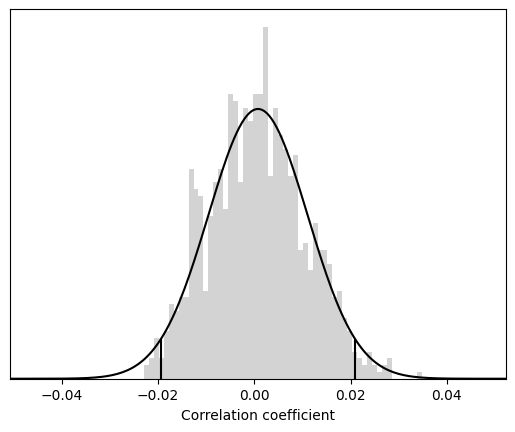

In [37]:
import mantel

dists1 = models_matrices[0]
dists2 = gold_matrix
assert dists1.shape == dists2.shape
dists1 = np.round(1-dists1, decimals=10)
#dists2 = np.round(1-dists2, decimals=10)
result = mantel.test(dists1, dists2, perms=1000, method='pearson')
print(f"Empirical p-value is {result.p} Veridical correlation is {round(result.r,3)}, Standard score (z-score) is {round(result.z,3)}")

fig, axis = mantel.plot(result)
fig.savefig('example.svg')

In [39]:
import mantel


"""Conducting the Mantel test across all the systems"""

result_data = []
resultp_printed = False
for i, matrix in enumerate(models_matrices):
    assert matrix.shape[0] == matrix.shape[1], f"Matrix {i} is not square"
    assert np.allclose(matrix, matrix.T), f"Matrix {i} is not symmetric"
    cos_sim = matrix
    dists2 = gold_matrix                                                        # 1 - inverted_gold_matrix
    assert cos_sim.shape == dists2.shape, f"Matrices {i} and inverted_gold_matrix have different shapes"
    dists1 = np.round(1-cos_sim, decimals=10)
    if i in [17, 23]:
        print(f'{models[i]} outputs not a valid condensed\
        or redundant distance matrix') #---------------------------------------> because of the vectors containing only 0 the 2 matrices do not form
        continue                                                                #  a valid condensed or redundant distance matrix
    try:
        result = mantel.test(dists1, dists2, perms=1000, method='pearson')
    except ValueError as e:
        raise ValueError(f"An error occurred during Mantel test: {e} in {models[i]}, {i}")
    result_data.append({
        'indix': i,
        'model': models[i],
        'p-value': result.p,
        'v_cor': result.r,
        'z_score': result.z
    })

sort_r_data = pd.DataFrame(result_data).set_index('model').sort_values(by='v_cor', ascending=False)
sort_r_data


wf_tfidf_facets_5_0.5_(1, 1)8k_711phon outputs not a valid condensed        or redundant distance matrix
wf_tfidf_facets_5_0.5_(1, 1)37k_711phon outputs not a valid condensed        or redundant distance matrix


,indix,p-value,v_cor,z_score
model,,,,
"sf_tfidf_facets_5_0.5_(1, 1)8k_711lang",8,0.001,0.497413,30.824845
"wf_tfidf_facets_5_0.5_(1, 1)8k_711raw",15,0.001,0.495572,30.470046
"wf_tfidf_facets_5_0.5_(1, 1)37k_711raw",21,0.001,0.490822,30.268069
"wf_tfidf_facets_5_0.5_(1, 1)37k_711lang",20,0.001,0.488670,30.297213
"wf_tfidf_facets_5_0.5_(1, 1)8k_711lang",14,0.001,0.488623,30.340136
"sf_tfidf_facets_5_0.5_(1, 1)8k_711morph",6,0.001,0.452816,30.586825
"sf_tfidf_facets_5_0.5_(1, 1)8k_711discourse",10,0.001,0.448519,30.532265
"sf_tfidf_facets_5_0.5_(1, 1)8k_711syntax",7,0.001,0.445023,30.326169
"sf_tfidf_facets_5_0.5_(1, 1)8k_711phon",11,0.001,0.436010,29.681427


## Additional analysis:

1.   Calculating familywise missranking among English and Russian data in CL setup
2.   Assessing authorship clustering



Obtaining language maps of meta-language subsets

In [20]:
with open("/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs711.json", "r") as en_f:
    en = json.load(en_f)
en_books = list(en.keys())
print(len(en_books), en_books[0])

711 sposato_xong2015.txt


In [19]:
with open("/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs_ru.json", "r") as ru_f:
    ru = json.load(ru_f)
ru_books = list(ru.keys())
print(len(ru_books), ru_books[0])

220 juldasev_bashkirskogo1981.txt


In [57]:
def variable(variable):
    variable_name = [name for name, value in globals().items() if value is variable][0]
    return variable_name


variable(family)

'turk1311'

In [58]:
best_ranking = models_r_m[sort_r_data.iloc[0, 0]] # ---------------------------> Selects the index of the best model in the Mantel test
stat = {
    'gold':[],
    'book':[],
    'bol':[],
    'bml':[]
}
print(f'for the {variable(family)} we have the following indices: {indices}')
for ind in indices:
    #print('GOLD:')
    #print(lang_ranking)
    for i, vec in enumerate(lang_ranking[ind:ind+1, :l_count+1]):
        stat['gold'].append(languages[vec[0]])
        stat['gold'].extend([languages[n] for n in vec[1:]])
        #print(f"Ranking for {languages[vec[0]]} the closest languages:{[languages[n] for n in vec[1:]]}")
    for i, vec in enumerate(best_ranking[ind:ind+1, :l_count+1]):
        stat['book'].append(books_lang[vec[0]])
        stat['book'].extend([books_lang[n] for n in vec[1:]])
        stat['bol'].append(languages[vec[0]])
        stat['bol'].extend([languages[n] for n in vec[1:]])
        stat['bml'].append('rus' if books_lang[vec[0]] in ru_books else 'eng')
        stat['bml'].extend(['rus' if books_lang[n] in ru_books else 'eng' for n in vec[1:]])
        # print(f"Ranking for {books_lang[vec[0]]} the closest books:{[books_lang[n] for n in vec[1:]]}")
        # print(f"Ranking for {languages[vec[0]]} the closest books:{[languages[n] for n in vec[1:]]}")
        # print(f"Ranking for {languages[vec[0]]} the closest books:{['rus' if books_lang[n] in ru_books else 'eng' for n in vec[1:]]}")

st = pd.DataFrame(stat)
st


for the turk1311 we have the following indices: [1, 32, 66, 67, 86, 109, 110, 119, 130, 131, 150, 171, 172, 206, 219, 227, 270, 306, 332, 338, 355, 356, 361, 370, 416, 472, 509, 527, 626, 640, 647, 688, 705]


,gold,book,bol,bml
0,uig,abdurehim_lopnor2014_o.txt,uig,eng
1,uig,dejong_uyghur2007v2_o.txt,uig,eng
2,uig,engsaeth_uyghur2009_o.txt,uig,eng
3,uig,hahn_spoken-uyghur1991_o.txt,uig,eng
4,uig,yakup_turfan-uyghur2005_o.txt,uig,eng
...,...,...,...,...
1117,tyv,abdurehim_lopnor2014_o.txt,uig,eng
1118,kim,li_yichun2018_s.txt,gan,eng
1119,kjh,chen_huian2011.txt,nan,eng
1120,tyv,vanschaaik_turkish2020.txt,tur,eng


In [49]:
count_not_family_ru = st[(st['bml'] == 'rus') & (~st['bol'].isin(family))]['book'].count()   # family is assignedin cell 14
count_not_family_en = st[(st['bml'] == 'eng') & (~st['bol'].isin(family))]['book'].count()
count_not_family_g = st[(st['gold'].isin(family))]['gold'].count()
count_ru = st[(st['bml']=='rus')]['book'].count()
count_en = st[(st['bml']=='eng')]['book'].count()

In [ ]:
"""manual fiiling up a table for the thesis"""


fam = 'bsk_ett_tzi_kgg_sux_eus_nll'

thesis_tab = {
    fam:[]
    }
thesis_tab[fam].extend(["Russian", "English"])

update_dict = {
    fam: [count_not_family_ru/count_ru, count_not_family_en/count_en]
}

thesis_tab.update(update_dict)

In [ ]:
pd.DataFrame(thesis_tab).T


,0,1
meta-language,Russian,English
Dravidian,0.909091,0.540909
Yukaghir,1.0,0.666667
Jarawa-Onge,NaN,1.0
Austronesian,NaN,0.53125
Nakh-Daghestanian,0.744853,0.822602
Tai-Kadai,0.928571,0.714286
Great Andamanese,NaN,0.5
Afro-Asiatic,NaN,0.324451
Uralic,0.763972,0.877497


In [44]:
st['author'] = st['book'].str.split('_').str[0]

""" Group by the 'author' column and count consecutive occurrences"""

consecutive_counts = st.groupby((st['author'] != st['author'].shift()).cumsum()).size()
unique_authors = st['author'].nunique()
print("Number of unique authors:", unique_authors)

author_counts = {}
current_author = None
consecutive_count = 0
current_lang = None
for index, row in st.iterrows():
    author = row['author']
    lang = row['bol']
    if author == current_author and lang != current_lang:
        consecutive_count += 1
    else:
        if current_author is not None:
            author_counts[current_author] = author_counts.get(current_author, 0) + consecutive_count
        current_author = author
        current_lang = lang
        consecutive_count = 0

author_counts[current_author] = author_counts.get(current_author, 0) + consecutive_count
sorted_counts = dict(sorted(author_counts.items(), key=lambda item: item[1], reverse=True))
print("Consecutive counts for each author:")
counts = 0
for author, count in sorted_counts.items():
    if count > 0:
        counts += count
        #print(author, ":", count)
print(counts)

Number of unique authors: 193
Consecutive counts for each author:
4


#Permutaion test

In [ ]:
"""Identification of SF anf WF counterparts' indices"""


for i, m in enumerate(models):
    if m == 'sf_tfidf_facets_5_0.5_(1, 1)8k_711discourse':
        print('sf:', i)

for i, m in enumerate(models):
    if m == 'wf_tfidf_facets_5_0.5_(1, 1)37k_711raw':
        print('wf:', i)

sf: 10
wf: 21


In [61]:
import numpy as np

"""Computing the significance difference between 2 models"""

x = 8
y = 20
sf_system = models_matrices[x].flatten()
wf_system = models_matrices[y].flatten()
z_1 = sort_r_data.loc[models[x], "z_score"]
z_2 = sort_r_data.loc[models[y], "z_score"]
print(f'For models {models[x]} and {models[y]}')
print(f'with shape {sf_system.shape} and {wf_system.shape}')
print(f'models z-scores: {z_1}, {z_2}')

def calculate_z_score(sample):
    sample_mean = np.mean(sample)
    sample_std = np.std(sample)
    return (sample_mean - np.mean(sf_system)) / (sample_std / np.sqrt(len(sample)))

num_samples = 1000
z_x = []
for _ in range(num_samples):
    sample = np.random.choice(sf_system, len(sf_system)//2, replace=False)
    sample = np.concatenate((sample, np.random.choice(wf_system, len(wf_system)//2, replace=False)))
    z_score = calculate_z_score(sample)
    z_x.append(z_score)
#print(z_scores[:20])
print(f"average z-score for permutations is {np.mean(np.array(z_x))}")
p_value = np.mean(np.array(z_x) < z_1)
print("P-value is:", p_value)

For models sf_tfidf_facets_5_0.5_(1, 1)8k_711lang and wf_tfidf_facets_5_0.5_(1, 1)37k_711lang
with shape (504100,) and (504100,)
models z-scores: 30.824844711168403, 30.297212920032596
average z-score for permutations is 80.32230917920131
P-value is: 0.0


# **3d Plotting**

## Creating language family dictionaries on the basis of Glottolog

In [ ]:
from pyglottolog import Glottolog



glottolog_repo_dir = "/content/glottolog"
glottolog = Glottolog(repos=glottolog_repo_dir)

languoids = glottolog.languoids()
dravidian = []
family_codes = set()
families = []
ls= []
for l in list(languoids):
    if str(l.iso_code) in list(langs.values()):
        ls.append(l)
        family_codes.add(l.family)

for family in list(family_codes):
    #print(family)
    if family is not None:
        families.append(family.glottocode)
    else:
        continue

In [ ]:
print(len(families), len(ls))

26 416


In [ ]:
from collections import defaultdict

family_codes = defaultdict(list)
languoids = glottolog.languoids()

for l in ls:
    for fam_code in families:
    #print(fam_code)
        if str(fam_code) in str(l.family) and l.iso_code is not None:
            #print(fam_code, l.family)
            assert fam_code in str(l.family.glottocode)
            family_codes[fam_code].append(l.iso_code)

print(len(family_codes), len(family_codes['drav1251']))

26 13


In [ ]:
for x,y in family_codes.items():
    print(x, y)

drav1251 ['brh', 'kru', 'kfd', 'bfq', 'xub', 'kan', 'iru', 'oty', 'tam', 'mal', 'mjr', 'kxu', 'wbq', 'gdb']
yuka1259 ['ykg', 'yux']
jara1244 ['anq']
aust1307 ['mbf', 'sci', 'zsm', 'mfa', 'huq', 'jra']
nakh1245 ['bbl', 'che', 'inh', 'kjj', 'lbe', 'ava', 'cji', 'kpt', 'ani', 'kva', 'tin', 'gdo', 'kap', 'huz', 'khv', 'gin', 'ddo', 'aqc', 'bdk', 'tab', 'lez', 'rut', 'tkr', 'dar']
taik1256 ['lbc', 'mmd', 'kmc', 'cov', 'zyb', 'pcc', 'lao', 'tha', 'lic', 'aou', 'lbt']
grea1241 ['abj', 'akj']
afro1255 ['arb', 'avl', 'yud', 'mlt', 'ayp', 'yhd', 'acw', 'acq', 'ayh', 'afb', 'abv', 'ars', 'adf', 'ayn', 'apc', 'rzh', 'arc', 'syc', 'mid', 'cld', 'aii', 'tmr', 'lsd', 'trg', 'huy', 'kqd', 'aij', 'bhn', 'uga', 'phn', 'smp', 'heb', 'hbo', 'shv', 'gdq', 'bhm', 'akk']
ural1272 ['sme', 'sje', 'sia', 'sms', 'sjt', 'sjd', 'mhr', 'izh', 'vep', 'fin', 'vot', 'kca', 'mns', 'nio', 'sel', 'yrk', 'enf', 'myv', 'udm', 'koi', 'kpv', 'hun']
abkh1242 ['uby', 'ady', 'kbd', 'abk', 'abq']
japo1237 ['ojp', 'jpn', 'ams', '

In [ ]:
inverted_ld = {}
for x, y in family_codes.items():
    for l in y:
        inverted_ld[l] = x

for k,v in inverted_ld.items():
    if k == 'sux':
        print(f'{k}:{v}')

## Checking the most frequent authors

In [ ]:
for k, v in sorted_langs.items():
    if "uslar_" in k:
        print(k, v)

uslar_abxazskij1887_o.txt abk
uslar_avarskij1889_o.txt ava
uslar_chechenskij1888v2_o.txt che
uslar_kjurinskij1896.txt lez
uslar_lakskij1890_o.txt lbe
uslar_tabasaranskij1979.txt tab
uslar_xjurkilinskij1892_o.txt dar


## Aligning data points with meta-languages

In [ ]:
with open("/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs_ru.json", "r") as ru_f:
    ru = json.load(ru_f)
ru_books = list(ru.keys())
print(len(ru_books), ru_books[0])

220 juldasev_bashkirskogo1981.txt


In [ ]:
with open("/content/drive/MyDrive/grammars/ws_removed_gr/book_language_map/langs711.json", "r") as en_f:
    en = json.load(en_f)
en_books = list(en.keys())
print(len(en_books), en_books[0])

711 sposato_xong2015.txt


## Plotting with familywise coloured datapoints

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import numpy as np



"""MULTILINGUAL"""

v_l = sorted_emb_df['ml_sf_tfidf_lang__5_0.5_(1, 1)8k_'].values                 # LaBSE: 'ml_sB_labse_pert_ml', TF-IDF:'ml_sf_tfidf_lang__5_0.5_(1, 1)8k_'
book_vectors = np.vstack(v_l)
print(book_vectors.shape)

pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(book_vectors)
model = PCA(n_components=3).fit(book_vectors)
print(model.explained_variance_ratio_.sum())
print(model.explained_variance_)
print(model.explained_variance_ratio_)
print(model.explained_variance_ratio_.cumsum())

categories = books_lang
class_names = np.array(list(languages))


colors = []
custom_colors = [
    '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7',
    '#dbdb8d', '#9edae5', '#c7e9c0', '#f4cae4', '#e0ecf4', '#fdd0a2',
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78',
    '#b3e2cd', '#c6dbef', '#f7f7f7', '#cbd5e8', '#ffffbf', '#fbe0f4'
]


fam_colors = {}
for f, c in zip(family_codes.keys(), custom_colors):
    fam_colors[f] = c

fam_colors['ett_bsk_nll_sux_eus_kgg'] = custom_colors[-1]
colors = []

"""______Settings to color familywise and to highlight an author__________"""
author_color = 'blue'
author = "khan_"   # <---------------------------------------------------------- author to check!
col_dict={}
b, col, markers = [], [], []
isolate_wth_fam = set()
assigned_color = 'lightgray'
for i, (book, lang) in enumerate(sorted_langs.items()):
    if book in ru_books:
        markers.append('square')
    if book in en_books:
        markers.append('circle')
    if lang not in inverted_ld:
        isolate_wth_fam.add(lang)
        col_dict[f'{i}_{lang}'] = custom_colors[-1]
        col.append(custom_colors[-1])
    elif author in book:
        b.append(book)
        col_dict[f'{i}_{lang}'] = author_color
        col.append(author_color)
        #markers.append('cross')
    else:
        col_dict[f'{i}_{lang}'] = fam_colors[inverted_ld[lang]]
        col.append(fam_colors[inverted_ld[lang]])
print(f"For the particular {author}: {book}")
print("list", len(markers))
#print("family_colors:", fam_colors)
print('isolate without family:', isolate_wth_fam)
colors = list(col_dict.values())
print(len(colors))

"""_____________to find an author, all the rest - gray____________________"""

# author_color = 'blue'
# for label, book in zip(languages, books_lang):
#     #print(label)
#     if "andronov" in book:
#         #print(label)
#         colors.append(author_color)
#     elif book in ru_books:
#         colors.append('lightgray')
#     elif book in en_books:
#         colors.append('lightgray')
"""_______________________________________________________________________"""


labels = books_lang
#assert type(labels) == list

fig = go.Figure()
for label, category in zip(np.unique(labels), categories):
    indices = np.where(np.array(labels) == label)[0]
    if indices.size > 0:
        fig.add_trace(go.Scatter3d(
            x=reduced_vectors[indices, 0],
            y=reduced_vectors[indices, 1],
            z=reduced_vectors[indices, 2],
            mode='markers',
            name=str(label),
            text=np.array(labels)[indices],                                     # Add labels to each point for hover
            hoverinfo='text',                                                   # Show labels on hover
            marker=dict(
                size=6,
                opacity=0.5,
                symbol=markers[indices[0]],
                color=colors[indices[0]]
            )
        ))


fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        bgcolor='white'                                                         # Set background color to white (seems not working!!!)
    ),
    width=1000,
    height=1000,
    title='PCA Visualization of Grammar Books Vectors (3D)',
    scene_camera=dict(
        eye=dict(x=1.87, y=0.88, z=-0.64)                                       # Set initial camera position
    ),
     legend=dict(
        orientation="v",
        yanchor="top",
        y=0.02,
        xanchor="right",
        x=1.02
    ),
    plot_bgcolor='white'                                                        # Set background color to white
)

fig.update_layout(paper_bgcolor="white")
# Show the plot
fig.show()


(927, 8000)
0.09206554332106454
[0.06080457 0.01651647 0.01171738]
[0.0628718  0.01707799 0.01211574]
[0.0628718  0.0799498  0.09206554]
For the particular khan_: zydenbos_kannada2011_o.txt
list 927
isolate without family: {'ett', 'bsk', 'nll', 'sux', 'tzi', 'eus', 'kgg'}
927


In [ ]:
names = ['Eskimo-Aleut', 'Japonic', 'Yukaghir', 'Abkhaz-Adyge', 'Great Andamanese', 'Kartvelian',
         'Ainu', 'Nakh-Daghestanian', 'Austroasiatic',  'Nivkh', 'Indo-European', 'Chukotko-Kamchatkan',
         'Hmong-Mien', 'Koreanic', 'Uralic',  'Turkic', 'Mongolic-Khitan', 'Austronesian',
          'Jarawa-Onge','Dravidian', 'Sign', 'Afro-Asiatic', 'Sino-Tibetan', 'Tungusic', 'Tai-Kadai', 'Yeniseian','bsk_ett_kgg_sux_eus_nll']
print(names)

['Eskimo-Aleut', 'Japonic', 'Yukaghir', 'Abkhaz-Adyge', 'Great Andamanese', 'Kartvelian', 'Ainu', 'Nakh-Daghestanian', 'Austroasiatic', 'Nivkh', 'Indo-European', 'Chukotko-Kamchatkan', 'Hmong-Mien', 'Koreanic', 'Uralic', 'Turkic', 'Mongolic-Khitan', 'Austronesian', 'Jarawa-Onge', 'Dravidian', 'Sign', 'Afro-Asiatic', 'Sino-Tibetan', 'Tungusic', 'Tai-Kadai', 'Yeniseian', 'bsk_ett_kgg_sux_eus_nll']


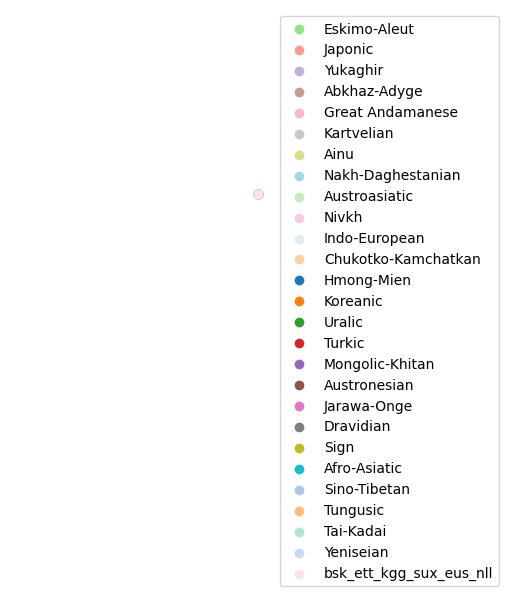

In [ ]:
import matplotlib.pyplot as plt

"""Create a small plot with a single point colored with the specified color for the family legend"""

for i, (f, c) in zip(names, fam_colors.items()):
    plt.scatter(0, 0, label = i, color=c)
    plt.axis('off')
    plt.legend()

In [ ]:
'sux' in inverted_ld.keys()

False

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import numpy as np


"""MONOLINGUAL"""


v_l = sorted_emb_df['sf_sB_labse_facets_pert_av_711_lang'].values               #sf_sB_labse_facets_pert_av_711_lang, 'sf_tfidf_facets_5_0.5_(1, 1)8k_711lang'
book_vectors = np.vstack(v_l)
print(book_vectors.shape)

pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(book_vectors)

categories = list(sorted_langs.keys())
class_names = np.array(list(languages))

custom_colors = [
    '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7',
    '#dbdb8d', '#9edae5', '#c7e9c0', '#f4cae4', '#e0ecf4', '#fdd0a2',
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78',
    '#b3e2cd', '#c6dbef', '#f7f7f7', '#cbd5e8', '#ffffbf', '#fbe0f4'
]
#plotly_colors.remove('lightgray')
#plotly_colors = px.colors.qualitative.Plotly      #MAX 10 colors!!!

fam_colors = {}
for f, c in zip(family_codes.keys(), custom_colors):
    fam_colors[f] = c
fam_colors['ett_bsk_nll_sux_eus_kgg'] = custom_colors[-1]
colors = []

"""______Settings to color familywise and to highlight an author__________"""
author_color = 'blue'
author = "khan_"   # <---------------------------------------------------------- author to check!
col_dict={}
col = []
isolate_wth_fam = set()
assigned_color = 'lightgray'
for i, (book, lang) in enumerate(sorted_langs.items()):
    if lang not in inverted_ld:
        isolate_wth_fam.add(lang)
        col_dict[f'{i}_{lang}'] = custom_colors[-1]
        col.append(custom_colors[-1])
    elif author in book:
        col_dict[f'{i}_{lang}'] = author_color
        col.append(author_color)
    else:
        col_dict[f'{i}_{lang}'] = fam_colors[inverted_ld[lang]]
        col.append(fam_colors[inverted_ld[lang]])

print("list", len(col))
print("dict", len(col_dict))
print('isolate without family:', isolate_wth_fam)
colors = list(col_dict.values())

"""_____Settings to color by author___________"""

# author_color = 'blue'
# for label, book in zip(languages, books_lang):
    #if label in family:
    # if "khan_" in book:
        #print(label)
        # colors.append(author_color)
    # elif book in en_books:
    #     colors.append('lightgray')

"""_______________________________________________"""


labels = list(sorted_langs.keys())
#print(np.unique(labels).shape)

fig = go.Figure()
for label, category in zip(np.unique(labels), categories):
    indices = np.where(np.array(labels) == label)[0]
    if indices.size > 0:
        #print("Color Index:", indices[0])
        #print("Colors:", colors)
        fig.add_trace(go.Scatter3d(
            x=reduced_vectors[indices, 0],
            y=reduced_vectors[indices, 1],
            z=reduced_vectors[indices, 2],
            mode='markers',
            name=str(label),
            text=np.array(labels)[indices],
            hoverinfo='text',
            marker=dict(
                size=6,
                opacity=0.5,
                color=colors[indices[0]]
            )
        ))

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
    ),
    width=1000,
    height=1000,
    title='PCA Visualization of Grammar Books Vectors (3D)',
    scene_camera=dict(
        eye=dict(x=1.87, y=0.88, z=-0.64)
    ),
     legend=dict(
        orientation="v",
        yanchor="top",
        y=0.02,
        xanchor="right",
        x=1.02
    )
)


(710, 12288)
list 710
dict 710
isolate without family: {'tzi', 'nll', 'sux', 'bsk', 'kgg', 'ett', 'eus'}


# TO DO:


1.  
2.  
3.   
4.   



